# ER Wait Time Exploratory Data Analysis (EDA) and Hypothesis Testing

This notebook is used to examine the cleaned ER Wait Time dataset with exploratory data analysis techniques and some statistical testing.

### Information about the raw ER Wait Time dataset and Source of the Data:
* The raw ER wait time dataset being handled within this notebook and used throughout the project **is the property of the Canadian Broadcasting Corporation (CBC)**.
    * Alberta Health Services is the primary source of the data, and CBC is the aggregator of the data.
    * The instantaneous wait times for each hospital in Alberta is at the follow Alberta Health Services website:  https://www.albertahealthservices.ca/waittimes/Page14230.aspx
    * CBC has aggregated the AHS data by recording the instantaneous wait time one per hour for all available hospitals from the AHS website.
    * The CBC reports on trends at each major city's ERs over the past 4 weeks here:
        * Calgary:  https://www.cbc.ca/news/canada/calgary/calgary-er-wait-time-tracker-cbc-1.6701714
        * Edmonton:  https://www.cbc.ca/news/canada/edmonton/edmonton-er-wait-time-tracker-cbc-1.6708480
    * The raw data being handled here and in this project is the full dataset underlying the news reports above, and has been provided courtesy of the CBC for the purposes of this data science bootcamp project.
        * As agreed with the CBC, the raw dataset will **not** be made available publically and **therefore this GitHub site does not include the raw .csv file in the `data` directory.**
* CBC's Journalistic Standards and Practises can be found here.  Expand the `Data Journalism` dropdown for pertinent information.
    * https://cbc.radio-canada.ca/en/vision/governance/journalistic-standards-and-practices/sources

In [1]:
from modules.utility import Utility
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for EDA plots
import seaborn as sns # for EDA plots
from scipy import stats # for Shapiro-Wilks test, ttest_ind, f_oneway
import pingouin as pg # for pg.welch_anova test for data with unequal variances

In [2]:
# # Uncomment code as required to force reload utility.py
# # Was only required during development of this notebook

# from importlib import reload
# import modules.utility
# reload(modules.utility)
# from modules.utility import Utility

In [79]:
# Save current sns color palette
current_palette = sns.color_palette()

# Setup

Remove display limits for column and row lengths, for easier viewing of dataframes

In [3]:
# Set no limits for number of columns and rows to display
# Utility.reset_display_max_cols_rows() to reset
Utility.setup_display_max_cols_rows()

Load the cleaned, melted dataset and also the cleaned dataset before it was pd_melt()'d

In [5]:
# Read in the pivoted, clean, final dataset
df = Utility.get_clean_waittimes_dataframe()

# Read in the raw dataset (which was before it was pd.melt()'ed)
raw = pd.read_csv(Utility.RAW_WAIT_DATETIME_DROP_NULL_HOSPITALS_DF_FILENAME)

In [6]:
df.head(5)

datetime                      hospital  waittime  year  \
0  2022-09-24 18:22:00   Alberta Children's Hospital     201.0  2022   
1  2022-09-24 18:22:00     Chinook Regional Hospital      69.0  2022   
2  2022-09-24 18:22:00        Devon General Hospital     132.0  2022   
3  2022-09-24 18:22:00      Foothills Medical Centre     188.0  2022   
4  2022-09-24 18:22:00  Fort Sask Community Hospital     295.0  2022   

  dayofweek  numdayofweek  weekofyear  hour dayperiod    id   services  \
0  Saturday             5          38    18   evening   ach  emergency   
1  Saturday             5          38    18   evening   crh  emergency   
2  Saturday             5          38    18   evening   dgh  emergency   
3  Saturday             5          38    18   evening   fmc  emergency   
4  Saturday             5          38    18   evening  fsch  emergency   

                city  cityarea  citypop citytype    hosplat    hosplong  
0            Calgary       826  1306784    urban  51.074759 -114.146833  
1         Lethbridge       122    98406     peri  49.685221 -112.816209  
2              Devon        14     6545    rural  53.352265 -113.728288  
3            Calgary       826  1306784    urban  51.064657 -114.130926  
4  Fort Saskatchewan        48    27088    rural  53.693175 -113.213436

In [7]:
raw.head(5)

Date  Year     Time             datetime  Alberta Children's Hospital  \
0  24-Sep  2022  6:22 PM  2022-09-24 18:22:00                        201.0   
1  24-Sep  2022  6:23 PM  2022-09-24 18:23:00                        201.0   
2  24-Sep  2022  8:25 PM  2022-09-24 20:25:00                        236.0   
3  24-Sep  2022  8:27 PM  2022-09-24 20:27:00                        236.0   
4  24-Sep  2022  8:28 PM  2022-09-24 20:28:00                        237.0   

   Foothills Medical Centre  Peter Lougheed Centre  \
0                     188.0                  116.0   
1                     188.0                  116.0   
2                     140.0                  124.0   
3                     140.0                  124.0   
4                     140.0                  124.0   

   Rockyview General Hospital  South Health Campus  Sheldon M. Chumir Centre  \
0                       148.0                154.0                      89.0   
1                       148.0                154.0                      89.0   
2                       120.0                150.0                      58.0   
3                       120.0                150.0                      58.0   
4                       106.0                151.0                      58.0   

   South Calgary Health Centre  Airdrie Community Health Centre  \
0                        193.0                              NaN   
1                        193.0                              NaN   
2                          NaN                              NaN   
3                          NaN                              NaN   
4                          NaN                              NaN   

   Cochrane Community Health Centre  Devon General Hospital  \
0                               NaN                   132.0   
1                               NaN                   132.0   
2                               NaN                   158.0   
3                               NaN                   158.0   
4                               NaN                   158.0   

   Grey Nuns Community Hospital  Misericordia Community Hospital  \
0                         147.0                            384.0   
1                         147.0                            384.0   
2                         224.0                            285.0   
3                         224.0                            285.0   
4                         216.0                            281.0   

   Royal Alexandra Hospital  Strathcona Community Hospital  \
0                     287.0                          196.0   
1                     287.0                          196.0   
2                     415.0                          251.0   
3                     415.0                          251.0   
4                     415.0                          251.0   

   University of Alberta Hospital  Fort Sask Community Hospital  \
0                           234.0                         295.0   
1                           234.0                         295.0   
2                           301.0                         188.0   
3                           301.0                         188.0   
4                           301.0                         188.0   

   Leduc Community Hospital  Northeast Community Health Centre  \
0                     293.0                              135.0   
1                     293.0                              135.0   
2                     158.0                              283.0   
3                     158.0                              283.0   
4                     158.0                              283.0   

   Stollery Children's Hospital  Sturgeon Community Hospital  \
0                         199.0                        261.0   
1                         199.0                        261.0   
2                         179.0                        203.0   
3                         179.0                        203.0   
4                         179.0               

Examine number of nulls in the raw df

In [8]:
Utility.print_num_stats(raw)

Stats for Number of Nulls:

Column Name                             :      Null Percentage     Num Nulls      Num Rows
-----------                             :      ---------------     ---------      --------
Date                                    :                 0.00%            0         9186
Year                                    :                 0.00%            0         9186
Time                                    :                 0.00%            0         9186
datetime                                :                 0.00%            0         9186
Alberta Children's Hospital             :                 0.82%           75         9186
Foothills Medical Centre                :                 1.01%           93         9186
Peter Lougheed Centre                   :                 0.90%           83         9186
Rockyview General Hospital              :                 0.85%           78         9186
South Health Campus                     :                 0.85%       

# Set up specific dataframes for groupings of data

Hospitals that have Emergency services only (no "Urgent Care" centres, which are limited to Calgary area anyways):

`df_er`

In [9]:
df_er = df[Utility.MASK_EMERGENCY_SERVICES(df)].copy()
df_er.head()

datetime                      hospital  waittime  year  \
0  2022-09-24 18:22:00   Alberta Children's Hospital     201.0  2022   
1  2022-09-24 18:22:00     Chinook Regional Hospital      69.0  2022   
2  2022-09-24 18:22:00        Devon General Hospital     132.0  2022   
3  2022-09-24 18:22:00      Foothills Medical Centre     188.0  2022   
4  2022-09-24 18:22:00  Fort Sask Community Hospital     295.0  2022   

  dayofweek  numdayofweek  weekofyear  hour dayperiod    id   services  \
0  Saturday             5          38    18   evening   ach  emergency   
1  Saturday             5          38    18   evening   crh  emergency   
2  Saturday             5          38    18   evening   dgh  emergency   
3  Saturday             5          38    18   evening   fmc  emergency   
4  Saturday             5          38    18   evening  fsch  emergency   

                city  cityarea  citypop citytype    hosplat    hosplong  
0            Calgary       826  1306784    urban  51.074759 -114.146833  
1         Lethbridge       122    98406     peri  49.685221 -112.816209  
2              Devon        14     6545    rural  53.352265 -113.728288  
3            Calgary       826  1306784    urban  51.064657 -114.130926  
4  Fort Saskatchewan        48    27088    rural  53.693175 -113.213436

Hospitals that have Emergency services only and not devoid of any WaitTimes, in the raw df:

`raw_er`

In [20]:
# Note, due to the cleaning that was done during data cleaning, the only hospital names that appear in the df_er are the hospitals that have at least one waittime.
desired_hospitals = df_er['hospital'].unique().tolist()

# We want those hospital columns plus the 'datetime' column in the raw df
desired_columns = ['datetime'] + desired_hospitals
raw_er = raw[desired_columns].copy()
raw_er.head()

datetime  Alberta Children's Hospital  \
0  2022-09-24 18:22:00                        201.0   
1  2022-09-24 18:23:00                        201.0   
2  2022-09-24 20:25:00                        236.0   
3  2022-09-24 20:27:00                        236.0   
4  2022-09-24 20:28:00                        237.0   

   Chinook Regional Hospital  Devon General Hospital  \
0                       69.0                   132.0   
1                       69.0                   132.0   
2                       79.0                   158.0   
3                       79.0                   158.0   
4                       73.0                   158.0   

   Foothills Medical Centre  Fort Sask Community Hospital  \
0                     188.0                         295.0   
1                     188.0                         295.0   
2                     140.0                         188.0   
3                     140.0                         188.0   
4                     140.0                         188.0   

   Grey Nuns Community Hospital  Leduc Community Hospital  \
0                         147.0                     293.0   
1                         147.0                     293.0   
2                         224.0                     158.0   
3                         224.0                     158.0   
4                         216.0                     158.0   

   Medicine Hat Regional Hospital  Misericordia Community Hospital  \
0                            96.0                            384.0   
1                            96.0                            384.0   
2                            60.0                            285.0   
3                            60.0                            285.0   
4                            60.0                            281.0   

   Northeast Community Health Centre  Peter Lougheed Centre  \
0                              135.0                  116.0   
1                              135.0                  116.0   
2                              283.0                  124.0   
3                              283.0                  124.0   
4                              283.0                  124.0   

   Red Deer Regional Hospital  Rockyview General Hospital  \
0                       161.0                       148.0   
1                       161.0                       148.0   
2                       241.0                       120.0   
3                       241.0                       120.0   
4                       230.0                       106.0   

   Royal Alexandra Hospital  South Health Campus  \
0                     287.0                154.0   
1                     287.0                154.0   
2                     415.0                150.0   
3                     415.0                150.0   
4                     415.0                151.0   

   Stollery Children's Hospital  Strathcona Community Hospital  \
0                         199.0                          196.0   
1                         199.0                          196.0   
2                         179.0                          251.0   
3                         179.0                          251.0   
4                         179.0                          251.0   

   Sturgeon Community Hospital  University of Alberta Hospital  \
0                        261.0                           234.0   
1                        261.0                           234.0   
2                        203.0                           301.0   
3                        203.0                           301.0   
4                        203.0                           301.0   

   WestView Health Centre  
0                   189.0  
1                   189.0  
2                   351.0  
3                   351.0  
4                   351.0

# Descriptive statistics for the entire dataset of Emergency hospitals

In [21]:
df_er.describe()

waittime           year   numdayofweek     weekofyear  \
count  181926.000000  181926.000000  181926.000000  181926.000000   
mean      207.487665    2022.775260       2.995927      28.367441   
std       121.728359       0.417412       2.001563      15.577043   
min        30.000000    2022.000000       0.000000       1.000000   
25%       120.000000    2023.000000       1.000000      14.000000   
50%       192.000000    2023.000000       3.000000      32.000000   
75%       273.000000    2023.000000       5.000000      42.000000   
max      1175.000000    2023.000000       6.000000      52.000000   

                hour       cityarea       citypop        hosplat  \
count  181926.000000  181926.000000  1.819260e+05  181926.000000   
mean       11.542446     467.732276  6.556983e+05      52.476358   
std         6.916522     363.621968  5.541452e+05       1.366765   
min         0.000000      14.000000  6.545000e+03      49.685221   
25%         6.000000      48.000000  6.823200e+04      51.074759   
50%        12.000000     768.000000  1.010899e+06      53.461578   
75%        18.000000     826.000000  1.306784e+06      53.556857   
max        23.000000     826.000000  1.306784e+06      53.693175   

            hosplong  
count  181926.000000  
mean     -113.506463  
std         0.714423  
min      -114.146833  
25%      -113.978897  
50%      -113.612231  
75%      -113.429674  
max      -110.703238

In [22]:
raw_er.describe()

Alberta Children's Hospital  Chinook Regional Hospital  \
count                  9111.000000                8822.000000   
mean                    199.572385                 102.804126   
std                     129.254659                  65.807900   
min                      30.000000                  30.000000   
25%                     115.000000                  52.000000   
50%                     170.000000                  89.000000   
75%                     247.000000                 136.000000   
max                    1036.000000                 593.000000   

       Devon General Hospital  Foothills Medical Centre  \
count             9139.000000               9093.000000   
mean               137.568881                247.315188   
std                 90.998597                 94.868087   
min                 30.000000                 30.000000   
25%                 55.000000                182.000000   
50%                123.000000                235.000000   
75%                201.000000                297.000000   
max                663.000000                775.000000   

       Fort Sask Community Hospital  Grey Nuns Community Hospital  \
count                   9138.000000                   9138.000000   
mean                     175.356095                    180.614467   
std                      114.524353                     79.754128   
min                       30.000000                     30.000000   
25%                       87.000000                    129.000000   
50%                      160.000000                    173.000000   
75%                      250.000000                    222.000000   
max                      863.000000                    600.000000   

       Leduc Community Hospital  Medicine Hat Regional Hospital  \
count               9138.000000                     8816.000000   
mean                 151.941125                       92.503063   
std                   91.975606                       59.517961   
min                   30.000000                       30.000000   
25%                   79.000000                       42.000000   
50%                  140.000000                       81.000000   
75%                  212.000000                      126.250000   
max                  548.000000                      443.000000   

       Misericordia Community Hospital  Northeast Community Health Centre  \
count                      9131.000000                        9139.000000   
mean                        289.894316                         209.492395   
std                         116.844342                         100.464304   
min                          30.000000                          30.000000   
25%                         208.000000                         140.000000   
50%                         277.000000                         197.000000   
75%                         357.500000                         261.000000   
max                         873.000000                         916.000000   

       Peter Lougheed Centre  Red Deer Regional Hospital  \
count            9103.000000                 9113.000000   
mean              295.444908                  258.548776   
std               158.920631                  136.640915   
min                30.000000                   30.000000   
25%               182.000000                  162.000000   
50%               263.000000                  235.000000   
75%               373.000000                  331.000000   
max              1175.000000                 1069.000000   

       Rockyview General Hospital  Royal Alexandra Hospital  \
count                 9108.000000               9138.000000   
mean                   223.920290                273.938499   
std                    110.241707                 96.761785   
min                     30.000000                 30.000000   
25%                    148.000000                206.000000   
50%                    198.000000                2

In [23]:
df_er.info()

<class 'pandas.core.frame.DataFrame'>
Index: 181926 entries, 0 to 201150
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   datetime      181926 non-null  object 
 1   hospital      181926 non-null  object 
 2   waittime      181926 non-null  float64
 3   year          181926 non-null  int64  
 4   dayofweek     181926 non-null  object 
 5   numdayofweek  181926 non-null  int64  
 6   weekofyear    181926 non-null  int64  
 7   hour          181926 non-null  int64  
 8   dayperiod     181926 non-null  object 
 9   id            181926 non-null  object 
 10  services      181926 non-null  object 
 11  city          181926 non-null  object 
 12  cityarea      181926 non-null  int64  
 13  citypop       181926 non-null  int64  
 14  citytype      181926 non-null  object 
 15  hosplat       181926 non-null  float64
 16  hosplong      181926 non-null  float64
dtypes: float64(3), int64(6), object(8)
memory usage: 25.0

In [24]:
raw_er.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9186 entries, 0 to 9185
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   datetime                           9186 non-null   object 
 1   Alberta Children's Hospital        9111 non-null   float64
 2   Chinook Regional Hospital          8822 non-null   float64
 3   Devon General Hospital             9139 non-null   float64
 4   Foothills Medical Centre           9093 non-null   float64
 5   Fort Sask Community Hospital       9138 non-null   float64
 6   Grey Nuns Community Hospital       9138 non-null   float64
 7   Leduc Community Hospital           9138 non-null   float64
 8   Medicine Hat Regional Hospital     8816 non-null   float64
 9   Misericordia Community Hospital    9131 non-null   float64
 10  Northeast Community Health Centre  9139 non-null   float64
 11  Peter Lougheed Centre              9103 non-null   float

# Histograms

### Across all ER Hospitals

Waittime across all ERs

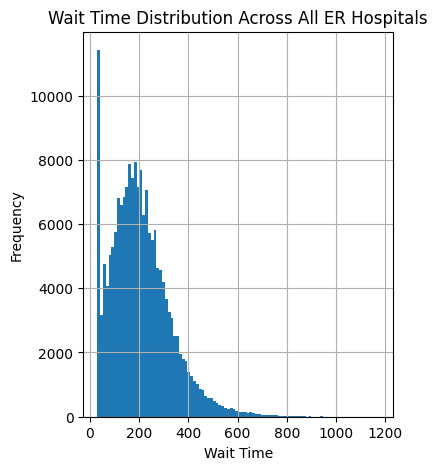

In [25]:
# Create histogram
ax = df_er[['waittime']].hist(bins=100, figsize=(4, 5))

# Label axes and title
ax[0, 0].set_xlabel("Wait Time")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].set_title("Wait Time Distribution Across All ER Hospitals")

# Show the plot
plt.show()

City Population Histogram Across All ER Hospitals

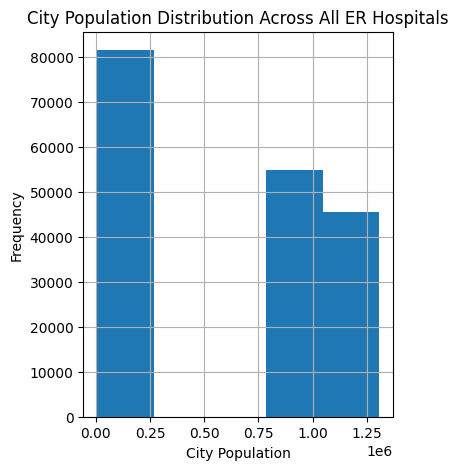

In [27]:
# Create histogram - citypop
ax = df_er[['citypop']].hist(bins=5, figsize=(4, 5))

# Label axes and title
ax[0, 0].set_xlabel("City Population")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].set_title("City Population Distribution Across All ER Hospitals")

# Show the plot
plt.show()

City Area Histogram Across All ER Hospitals

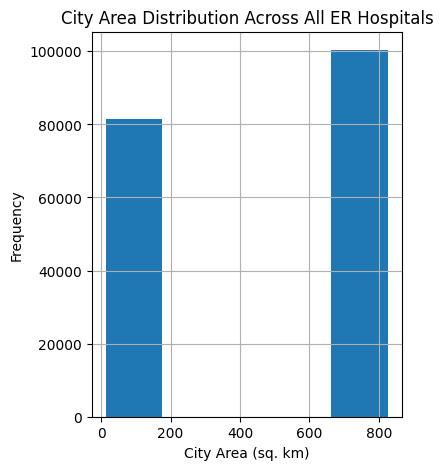

In [28]:
# Create histogram - cityarea
ax = df_er[['cityarea']].hist(bins=5, figsize=(4, 5))

# Label axes and title
ax[0, 0].set_xlabel("City Area (sq. km)")
ax[0, 0].set_ylabel("Frequency")
ax[0, 0].set_title("City Area Distribution Across All ER Hospitals")

# Show the plot
plt.show()

### Across Individual ER Hospitals

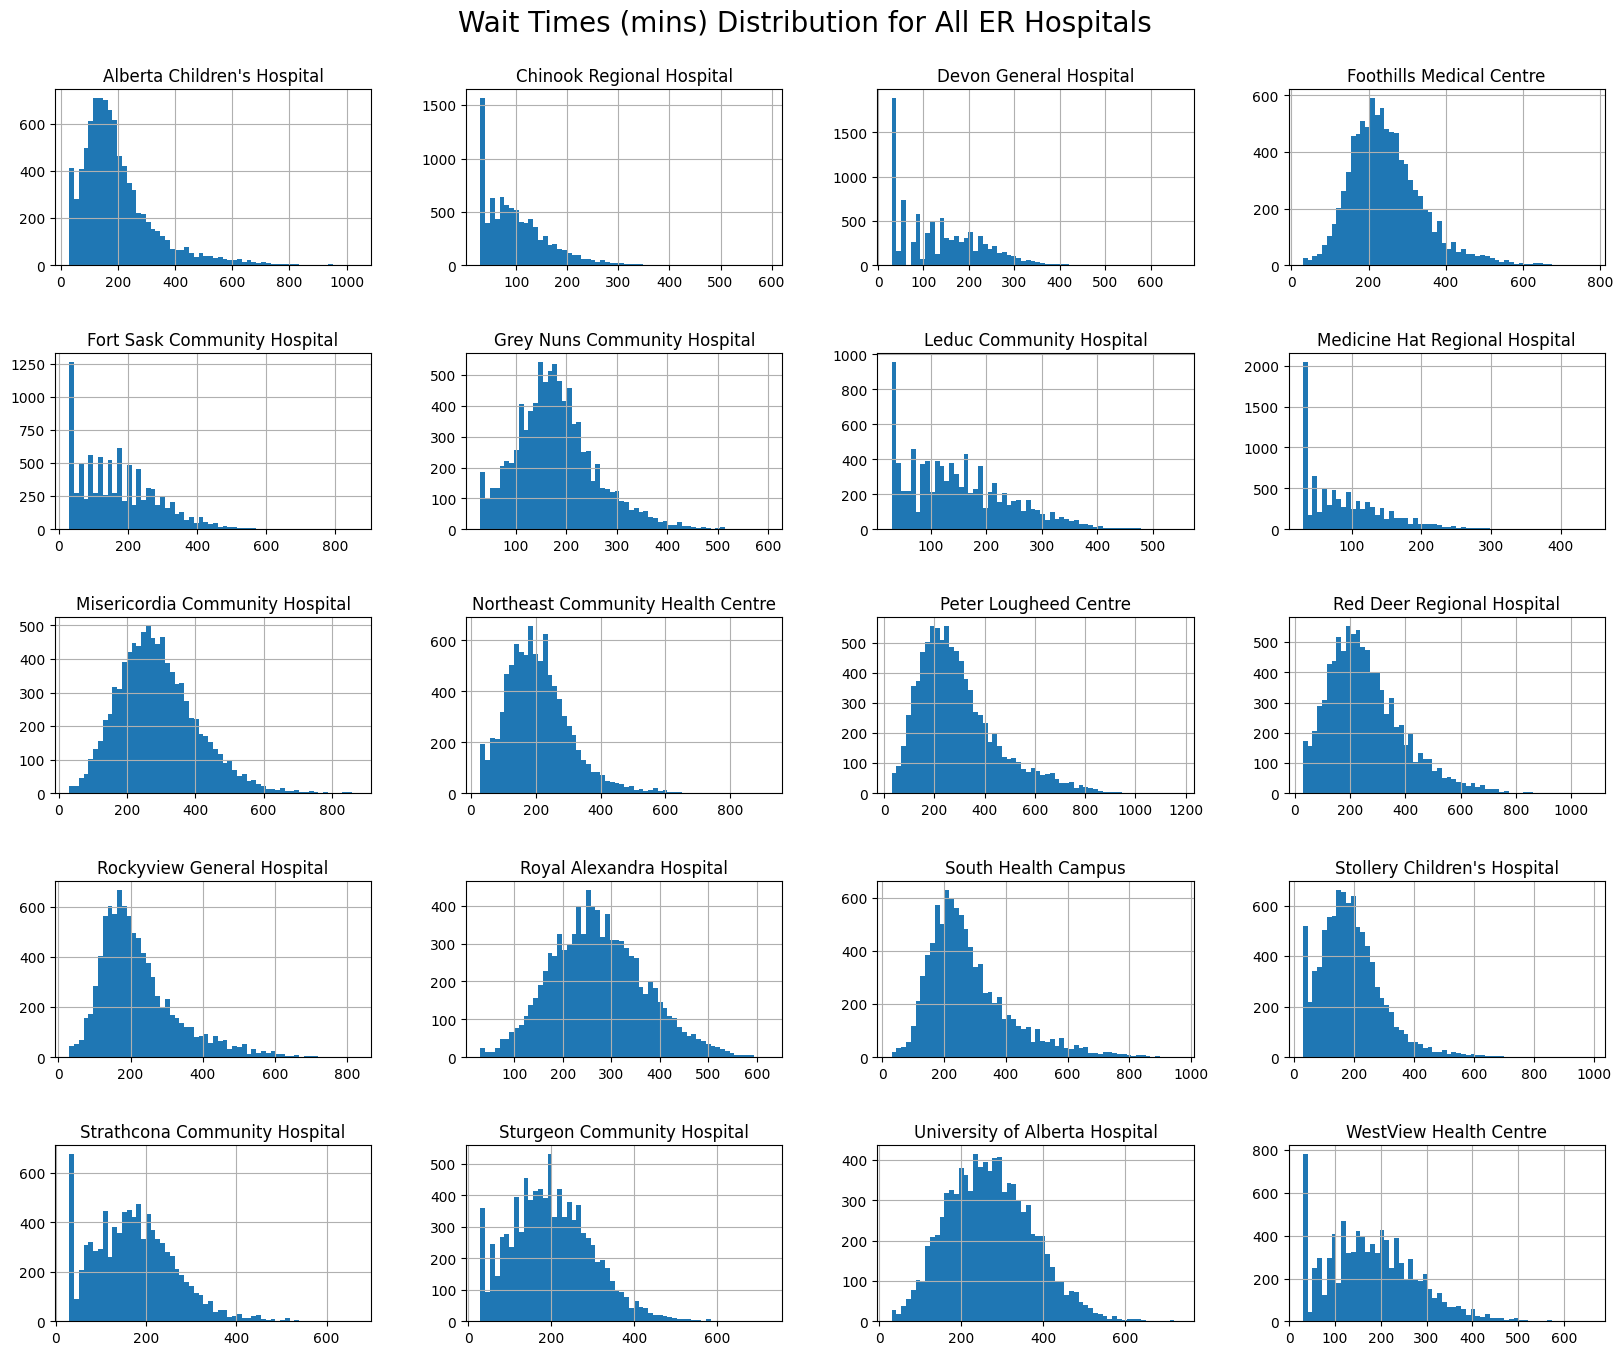

In [43]:
# Draw histograms of wait times for all ER hospitals
raw_er.drop('datetime', axis=1).hist(bins=60, figsize=(20, 16))

# Add more whitespace between rows of histograms
plt.subplots_adjust(hspace=0.5)  # Adjust this value as needed for space between rows

# Adjust the super title with less whitespace above
plt.suptitle('Wait Times (mins) Distribution for All ER Hospitals', fontsize=20, y=0.93)

plt.show()

# What weeks of the year are missing from the data set?

In [57]:
df_er['weekofyear'].value_counts().sort_index()

weekofyear
1     3340
2     3340
3     3338
4     2904
5     3354
6     3360
7     3360
8     3340
9     3352
10    3336
11    3358
12    3360
13    3339
14    3360
15    3318
16    3340
17    3354
18    3125
19    3360
20    3358
21    3360
22    3161
23    3197
24    3217
25    3317
26    3314
27    1340
31    2060
32    3360
33    3360
34    3360
35    3347
36    3360
37    3325
38    4100
39    6691
40    6644
41    6660
42    4640
43    3340
44    5722
45    6712
46    6700
47    4609
48    3310
49    3350
50    3360
51    3354
52    3360
Name: count, dtype: int64

Weeks 28, 29, and 30 are missing.  What months and days do these correspond to?

In [62]:
from datetime import datetime

weeks_missing = [28, 29, 30]
for week in weeks_missing:
    iso_string = f'2023-W{week}-1'
    start_date = datetime.strptime(iso_string, '%Y-W%W-%w')
    print(f"For week {week}, starting Monday of the week is: {start_date.strftime('%Y-%m-%d')}")
          
print(f"According to https://calstampede.com/, Calgary Stampede ran between Friday, July 7, 2023 and Sunday, July 16, 2023, inclusive.")

For week 28, starting Monday of the week is: 2023-07-10
For week 29, starting Monday of the week is: 2023-07-17
For week 30, starting Monday of the week is: 2023-07-24
According to https://calstampede.com/, Calgary Stampede ran between Friday, July 7, 2023 and Sunday, July 16, 2023, inclusive.


Findings: The dataset is missing crucial data for the week of Calgary Stampede, which is a major event in Calgary. This is a limitation of the dataset.

# Normality

waittime across all ER hospitals

In [45]:
# Kolmorogov-Smirnov test for normality, for high N
#print (f"Kolmorogov-Smirnov test for normality, for high N:  Test waittime across all ER hospitals:\n")
stat, p = stats.kstest(df_er['waittime'], 'norm')
#print (f"Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value={p}.  Data are{'**NOT**' if round(p, 2) < 0.05 else ''} normally distributed.")
print("Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value={:>9}.  Data are{:>9} normally distributed.".format(p, '**NOT**' if round(p, 2) < 0.05 else ''))

Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value=      0.0.  Data are  **NOT** normally distributed.


waittime at each ER hospital

In [50]:
# Kologorov-Smirnov test for normality, for each hospital that has any waittime data
print (f"Kolmorogov-Smirnov test for normality, for high N:  Test for each ER hospital:\n")
for hosp in desired_hospitals:
    if df_er[df_er['hospital'] == hosp].shape[0] > 0:
        stat, p = stats.kstest(df_er[df_er['hospital'] == hosp]['waittime'], 'norm')
        #print (f"{hosp}: Kolmogorov-Smirnov test p-value={p}.  Data are{'**NOT**' if round(p, 2) < 0.05 else ''} normally distributed.")
        print("{:<40}: Kolmogorov-Smirnov test p-value={:>5}.  Data are {:>7} normally distributed.".format(hosp, p, '**NOT**' if round(p, 2) < 0.05 else ''))

Kolmorogov-Smirnov test for normality, for high N:  Test for each ER hospital:

Alberta Children's Hospital             : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Chinook Regional Hospital               : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Devon General Hospital                  : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Foothills Medical Centre                : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Fort Sask Community Hospital            : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Grey Nuns Community Hospital            : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Leduc Community Hospital                : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Medicine Hat Regional Hospital          : Kolmogorov-Smirnov test p-value

# Barplots of Wait Times by Hospital

By Day of Week

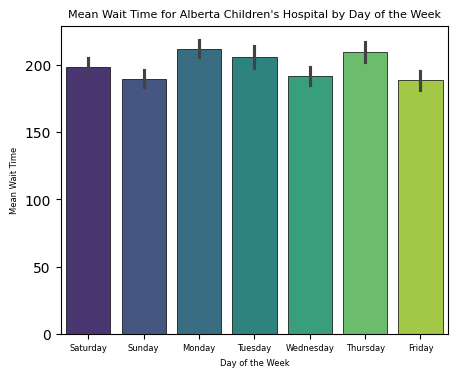

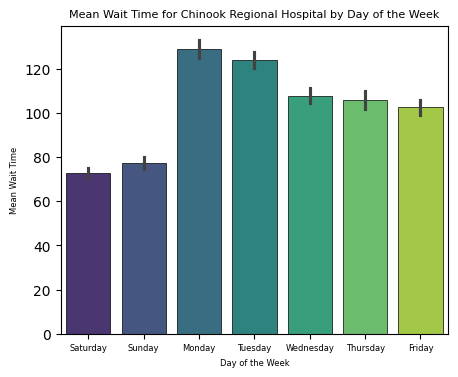

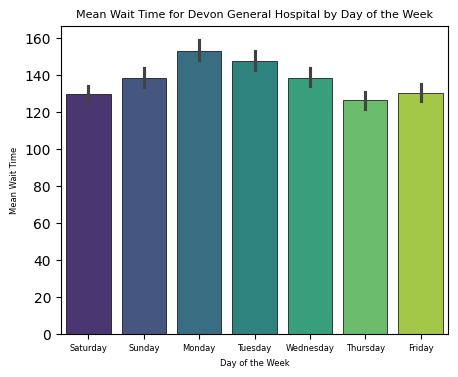

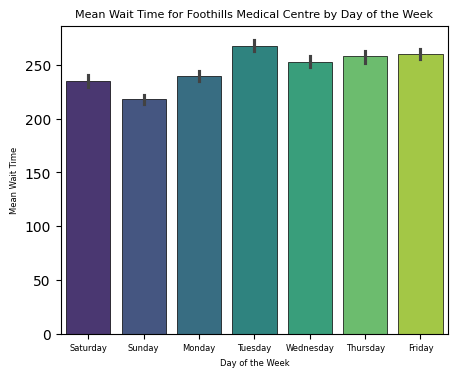

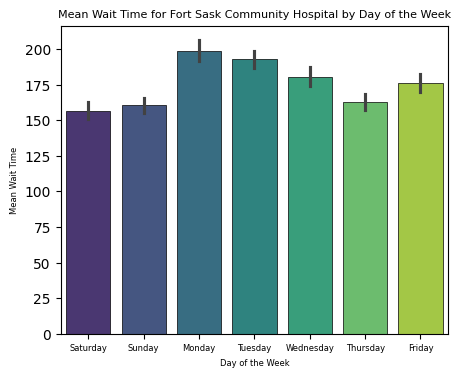

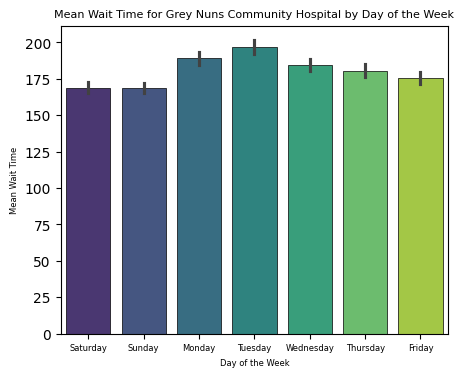

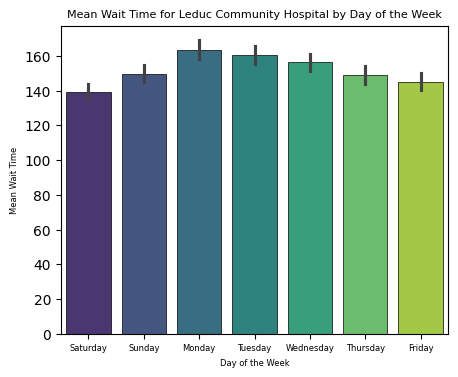

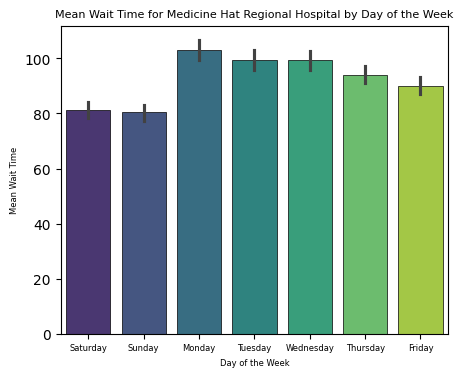

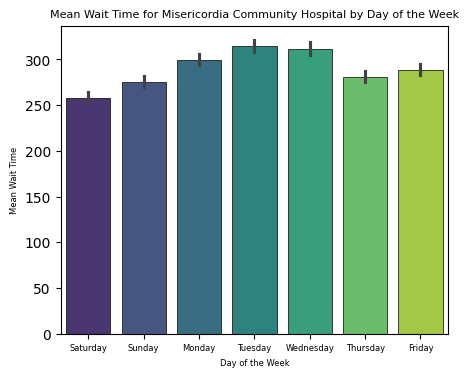

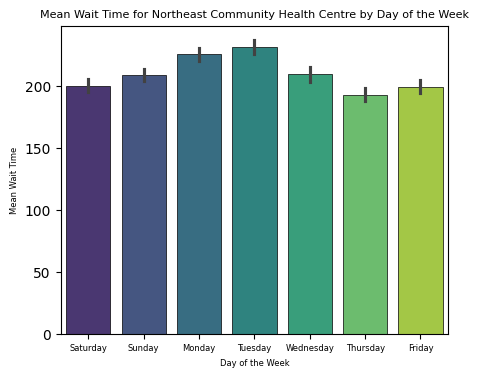

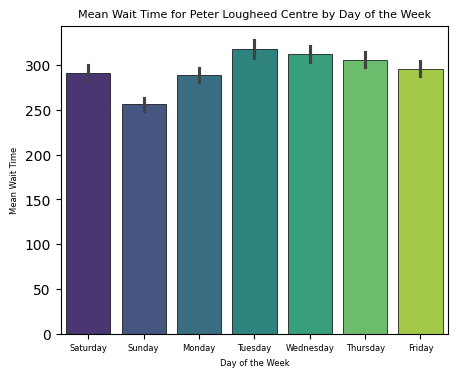

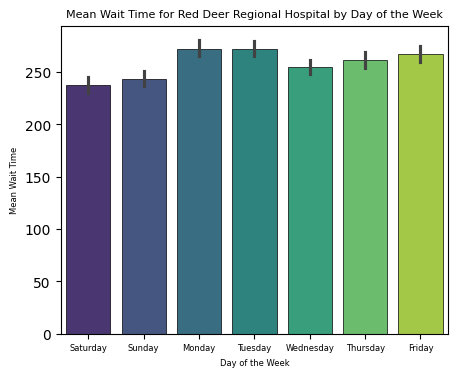

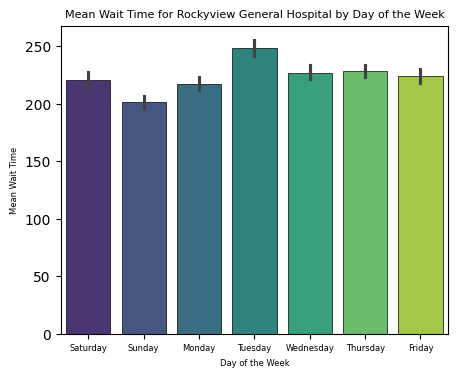

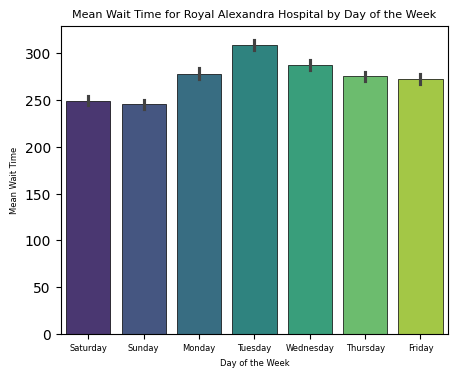

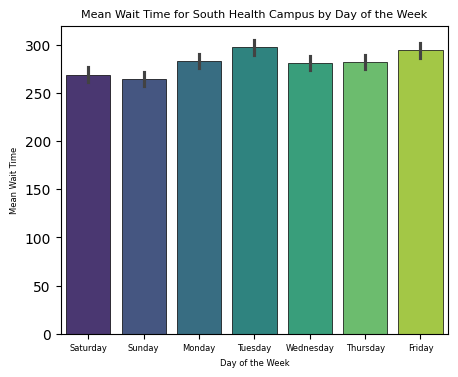

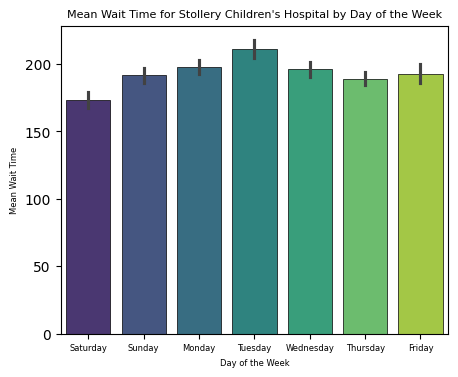

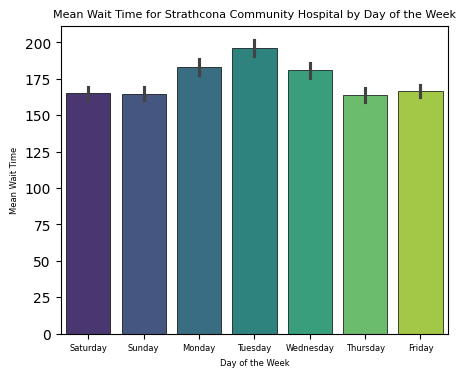

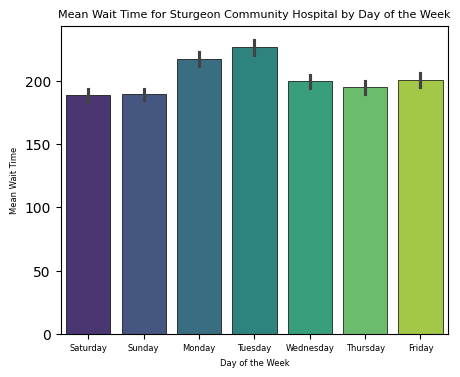

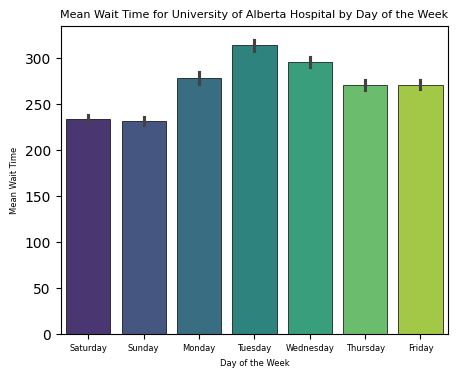

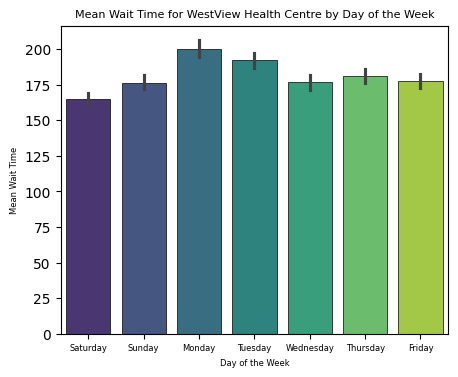

In [51]:
# Make a plot for each hospital in hospital_names:
for hospital in desired_hospitals:
    data_df = df_er[df_er['hospital'] == hospital]
    
    # Create a new subplot for each hospital
    plt.figure(figsize=(5,4))
    
    # Plot the bar graph for the current hospital
    sns.barplot(data=data_df, x='dayofweek', y='waittime', hue='dayofweek', palette='viridis', linewidth=0.5, edgecolor='black')
    
    # Set title and labels
    plt.title(f'Mean Wait Time for {hospital} by Day of the Week', fontsize=8)
    plt.xlabel('Day of the Week', fontsize=6)
    plt.ylabel('Mean Wait Time', fontsize=6)
    plt.xticks(fontsize=6)
    # Show or save the plot as needed
    plt.show()

Plot of Day of Week changes by Hospital as a line plot

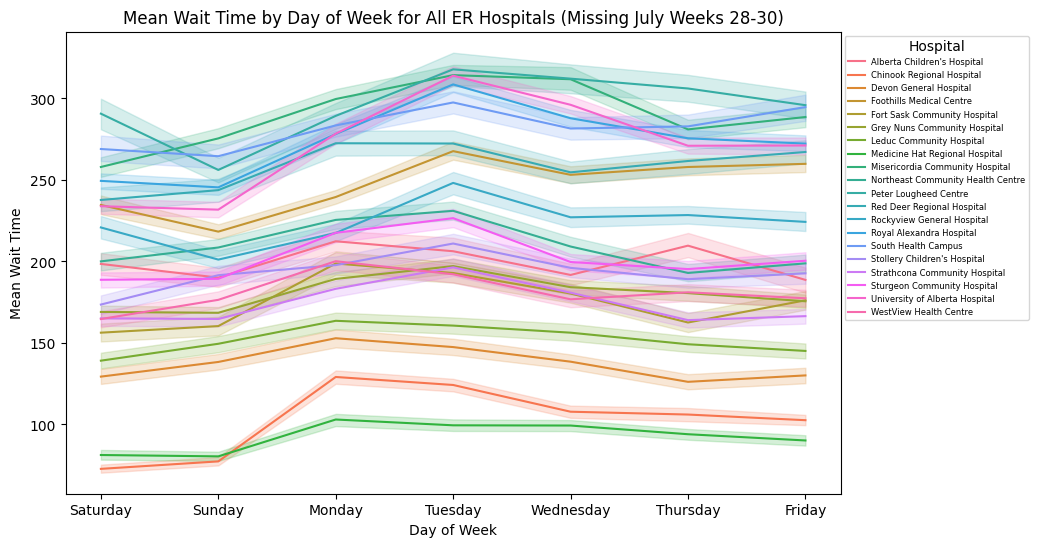

In [159]:
# Create figure and set color palette
plt.figure(figsize=(10,6));
sns.set_palette("tab10")

# Create line plot
#sns.lineplot(data=df_er, x='dayofweek', y='waittime', errorbar='sd', hue='hospital');
sns.lineplot(data=df_er, x='dayofweek', y='waittime', hue='hospital', errorbar='ci');

# Set title and labels
plt.title('Mean Wait Time by Day of Week for All ER Hospitals (Missing July Weeks 28-30)', fontsize=12);
plt.xlabel('Day of Week', fontsize=10);
plt.ylabel('Mean Wait Time', fontsize=10);

# Set legend
plt.legend(title='Hospital', loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6);

By Week of Year

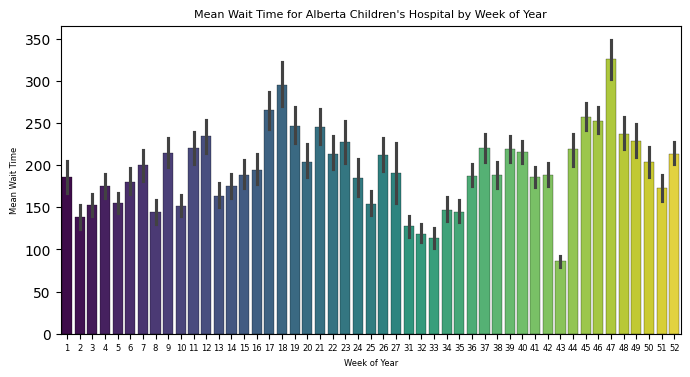

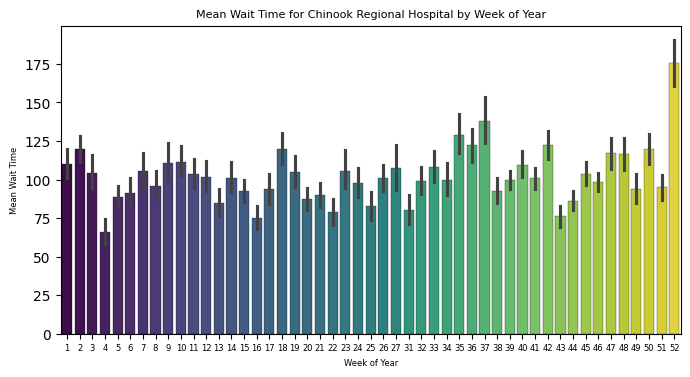

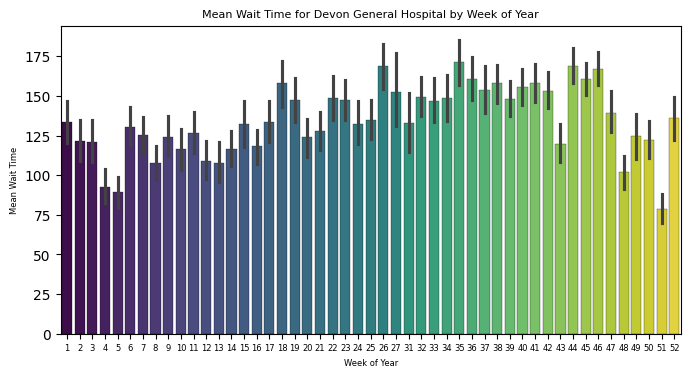

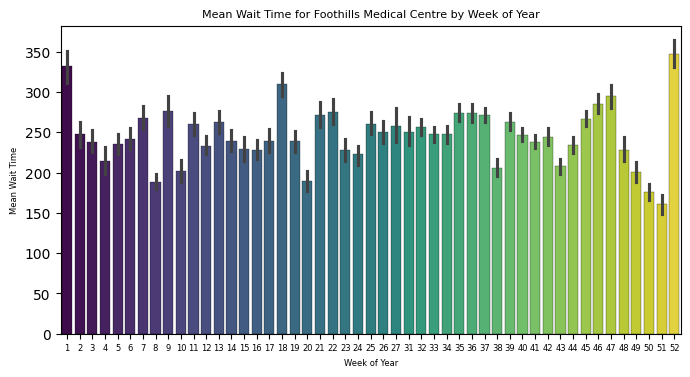

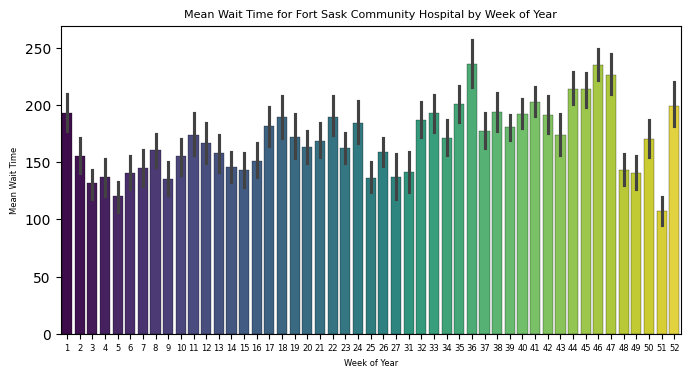

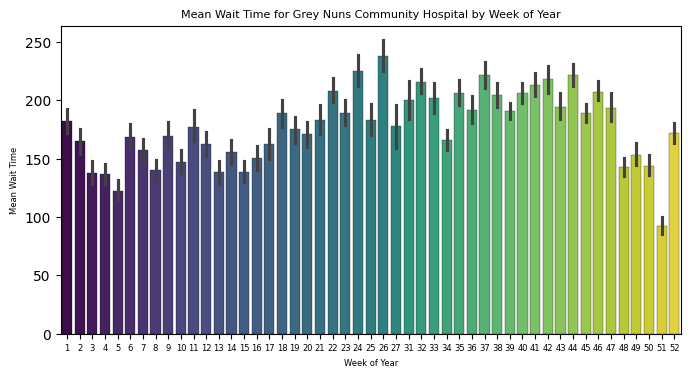

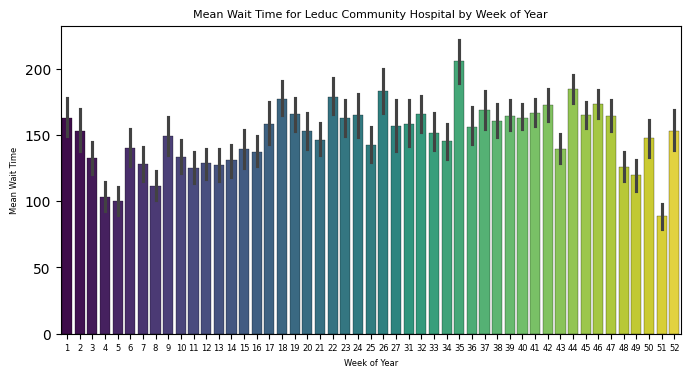

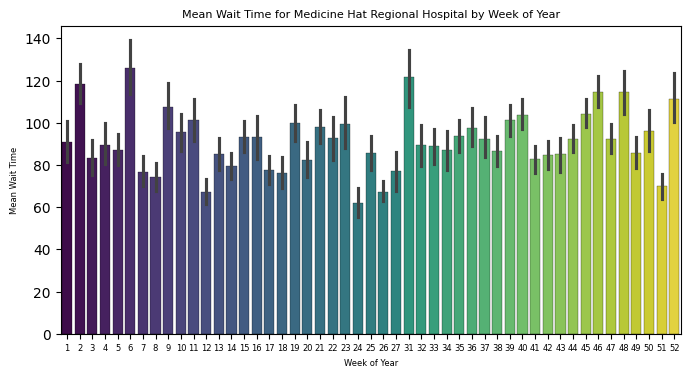

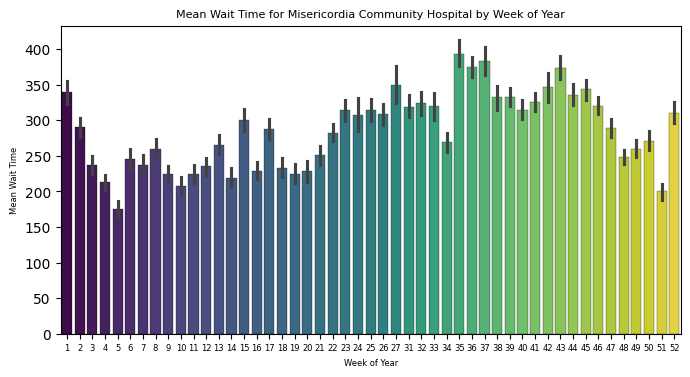

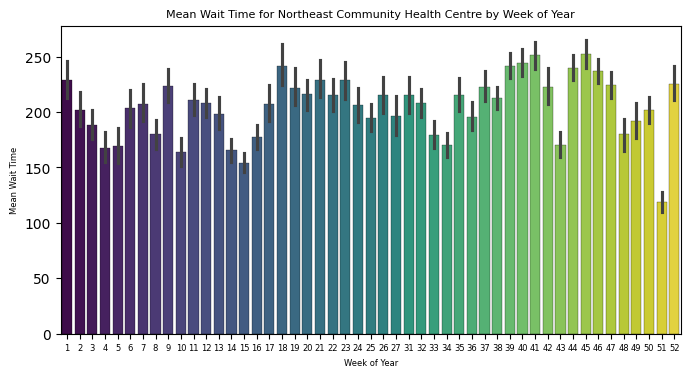

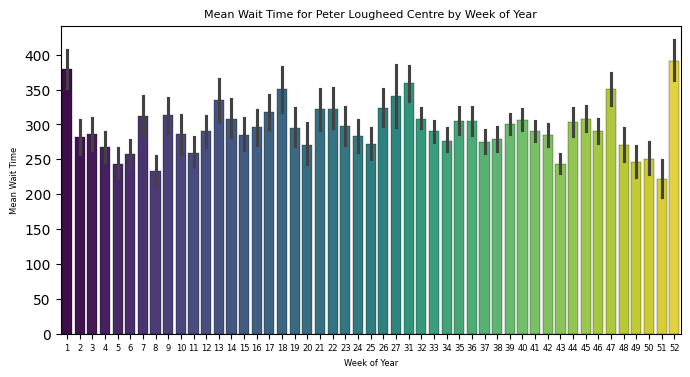

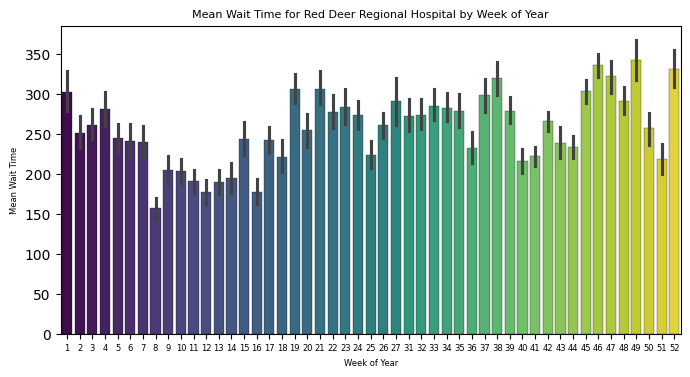

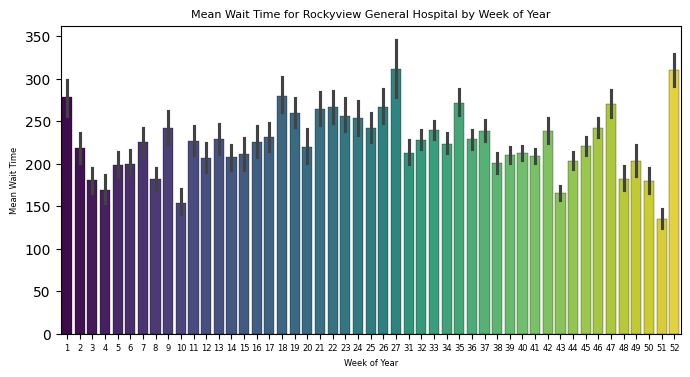

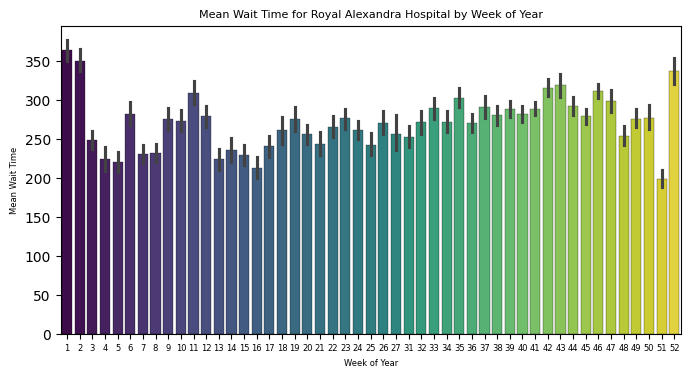

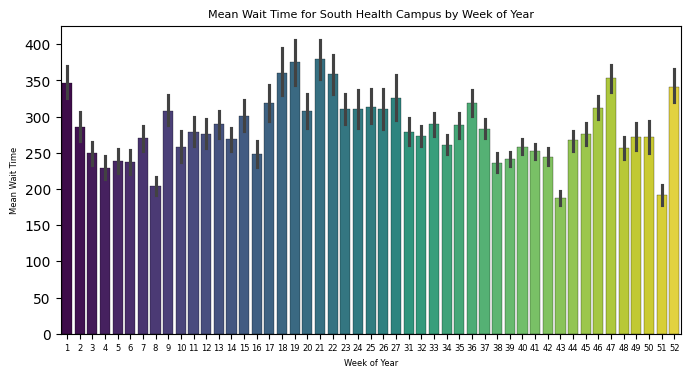

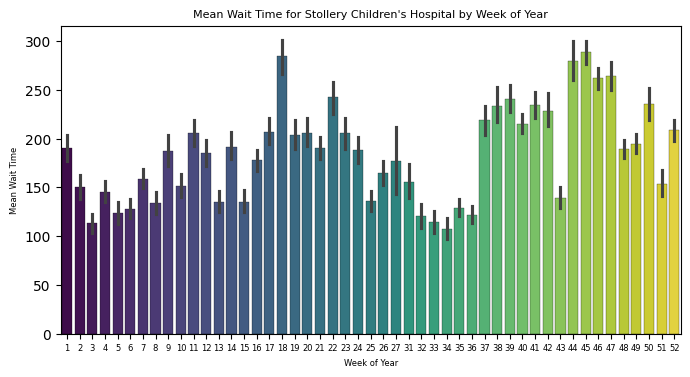

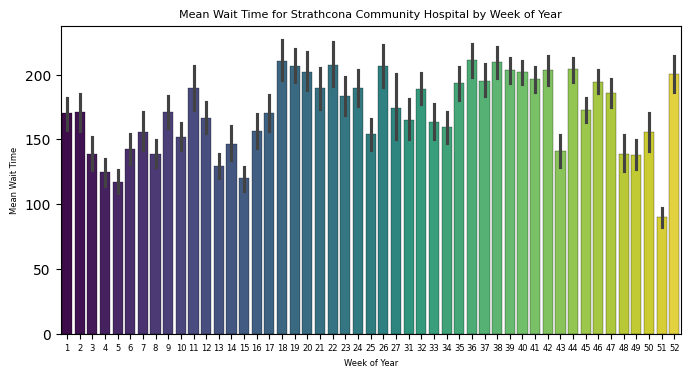

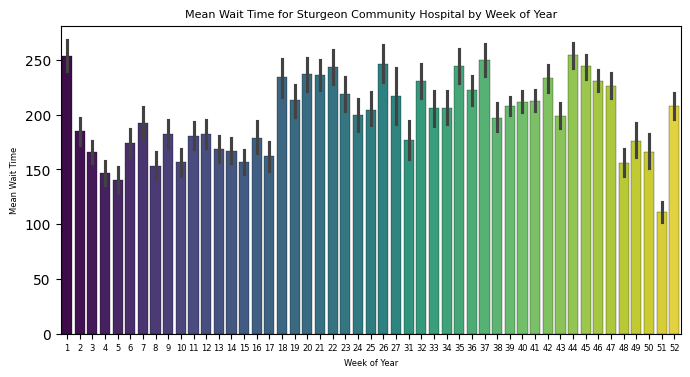

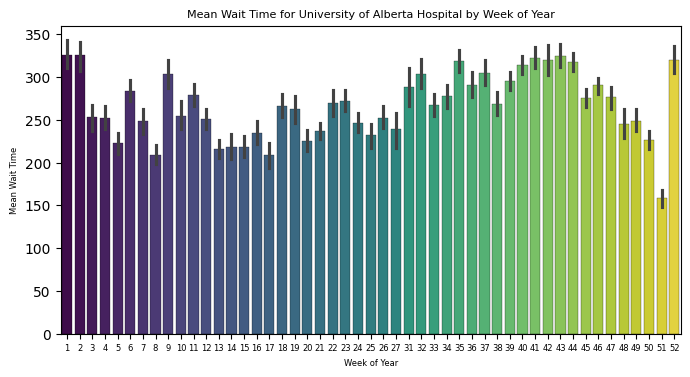

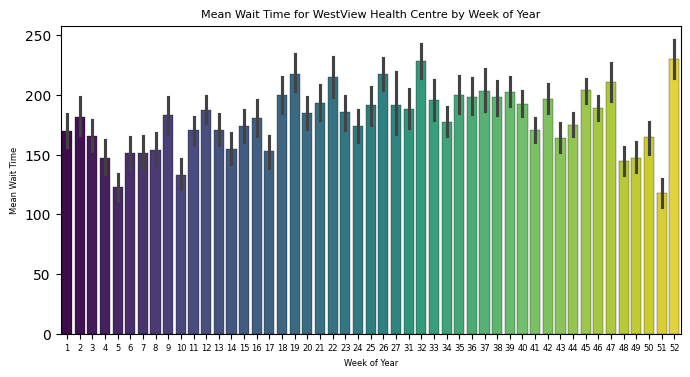

In [53]:
# Make a plot for each hospital in hospital_names:
for hospital in desired_hospitals:
    data_df = df_er[df_er['hospital'] == hospital]
    
    # Create a new subplot for each hospital
    plt.figure(figsize=(8,4))
    
    # Plot the bar graph for the current hospital
    sns.barplot(data=data_df, x='weekofyear', y='waittime', hue='weekofyear', palette='viridis', linewidth=0.2, edgecolor='black', legend=False)
    
    # Set title and labels
    plt.title(f'Mean Wait Time for {hospital} by Week of Year', fontsize=8)
    plt.xlabel('Week of Year', fontsize=6)
    plt.ylabel('Mean Wait Time', fontsize=6)
    plt.xticks(fontsize=6)
    # Show or save the plot as needed
    plt.show()

Plot of Week of Year changes by Hospital as a line plot

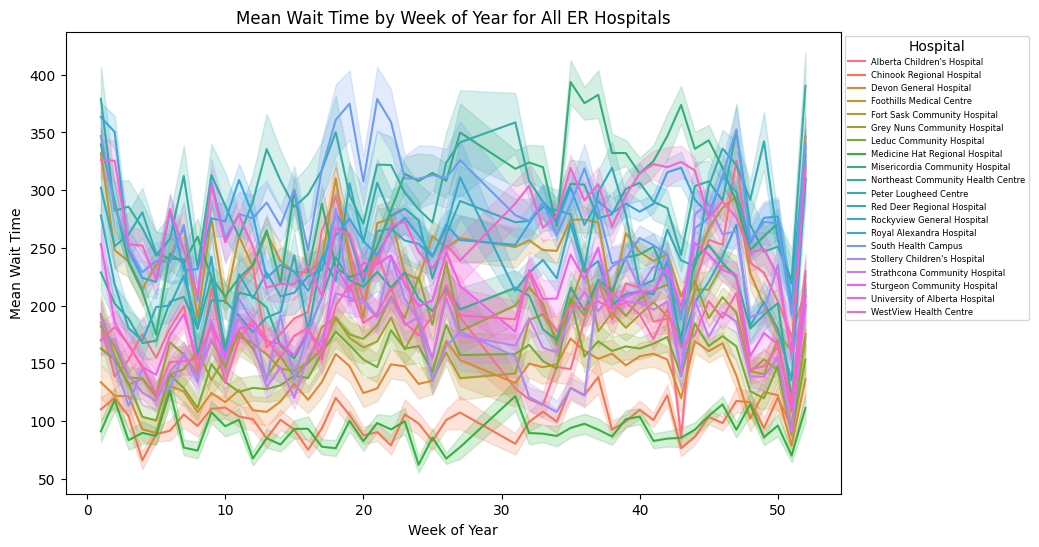

In [78]:
# Create figure and set color palette
plt.figure(figsize=(10,6));
sns.set_palette("tab10")

# Create line plot
#sns.lineplot(data=df_er, x='weekofyear', y='waittime', errorbar='sd', hue='hospital');
sns.lineplot(data=df_er, x='weekofyear', y='waittime', hue='hospital');

# Set title and labels
plt.title('Mean Wait Time by Week of Year for All ER Hospitals (Missing July Weeks 28-30)', fontsize=12);
plt.xlabel('Week of Year', fontsize=10);
plt.ylabel('Mean Wait Time', fontsize=10);

# Set legend
plt.legend(title='Hospital', loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6);

By Hour of Day

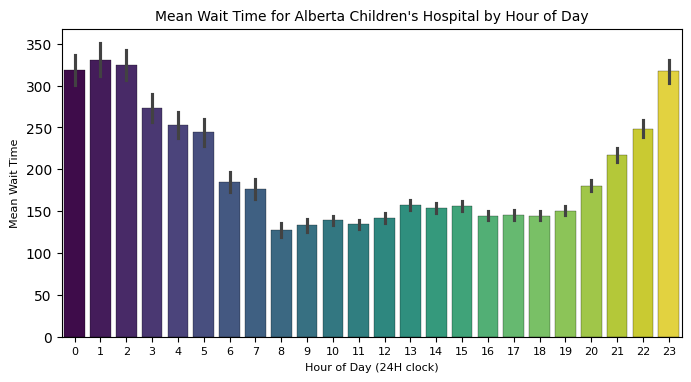

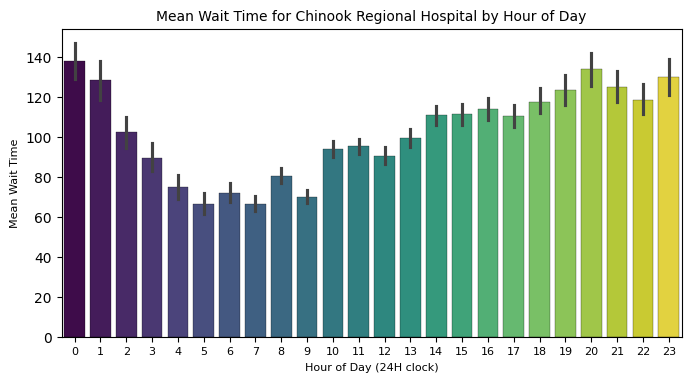

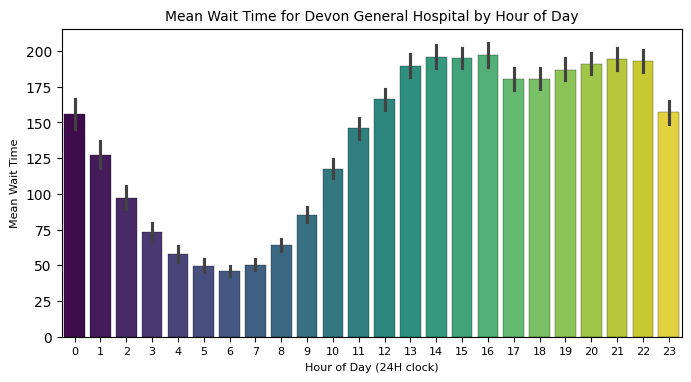

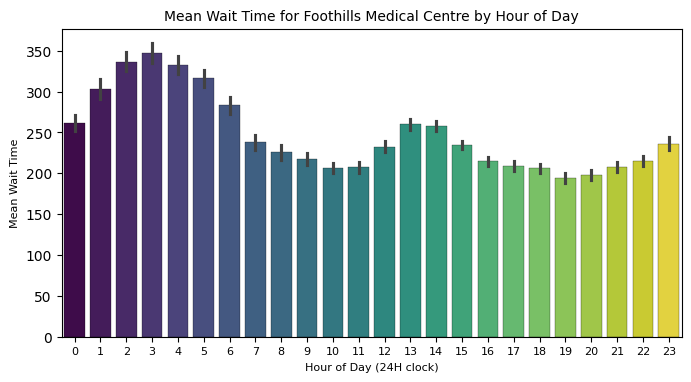

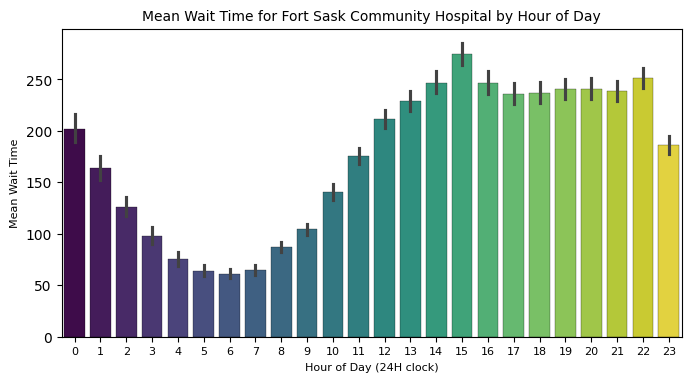

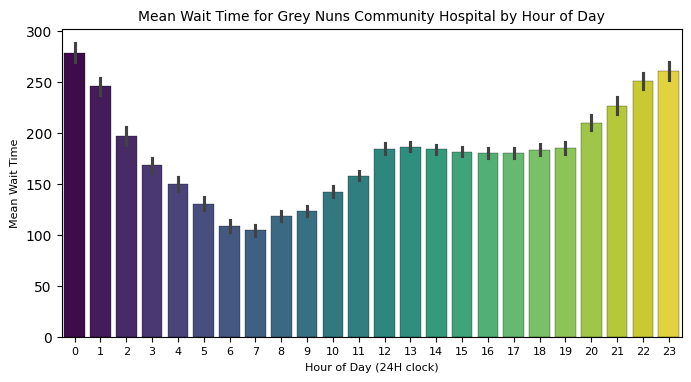

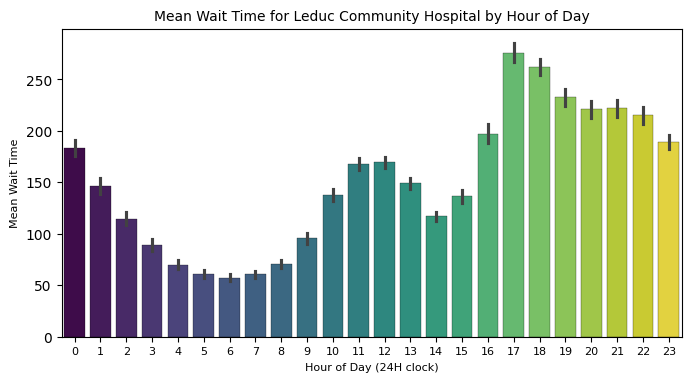

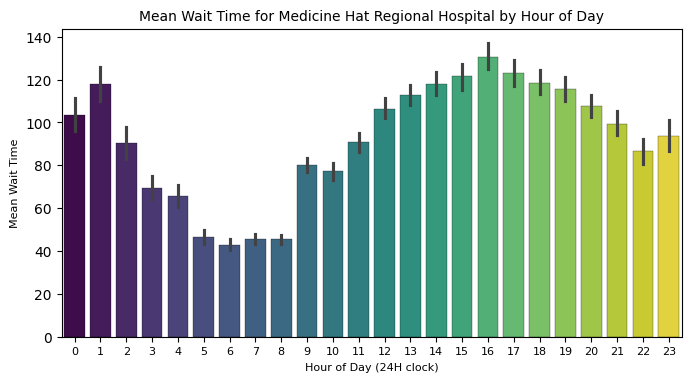

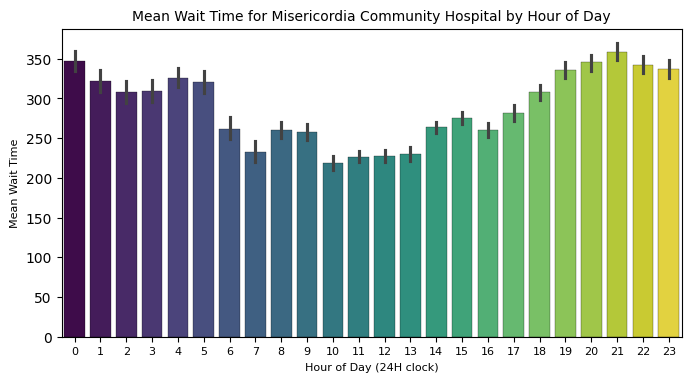

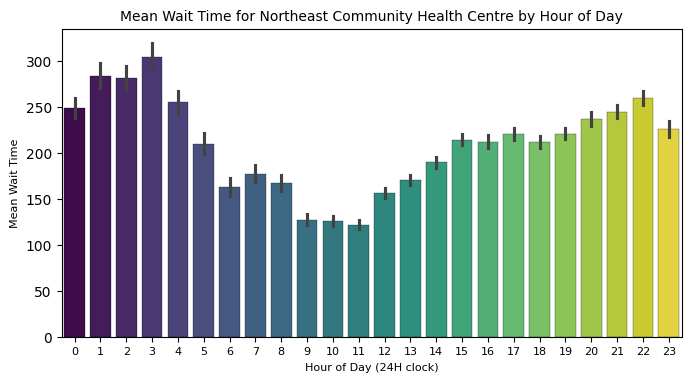

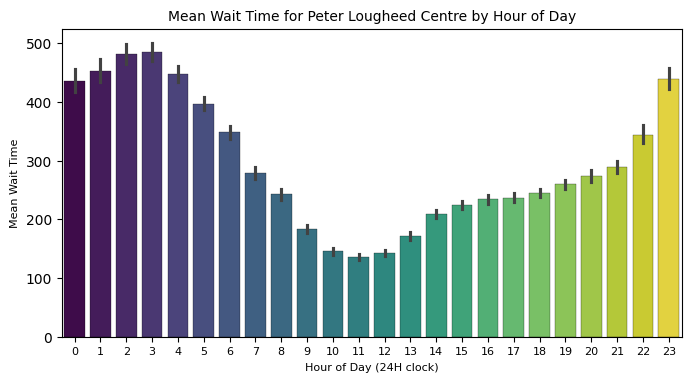

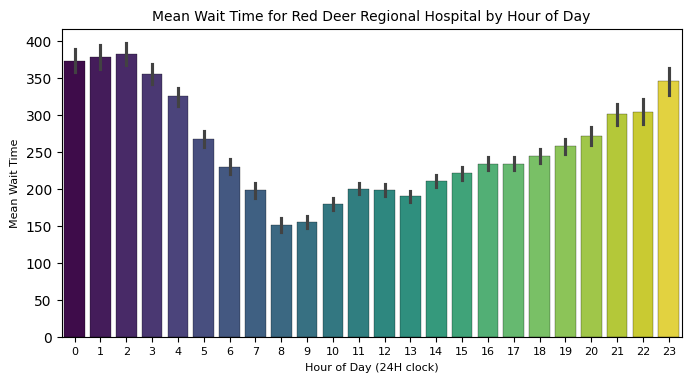

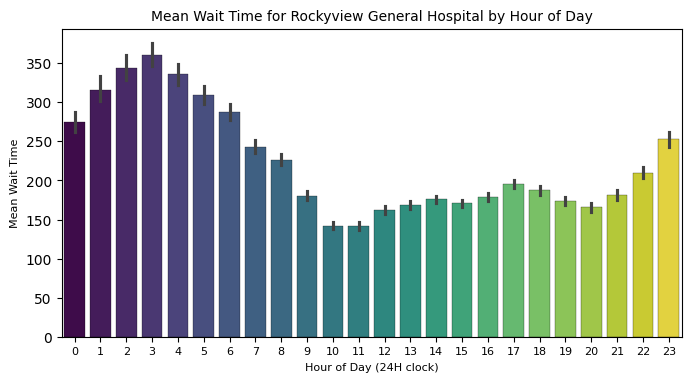

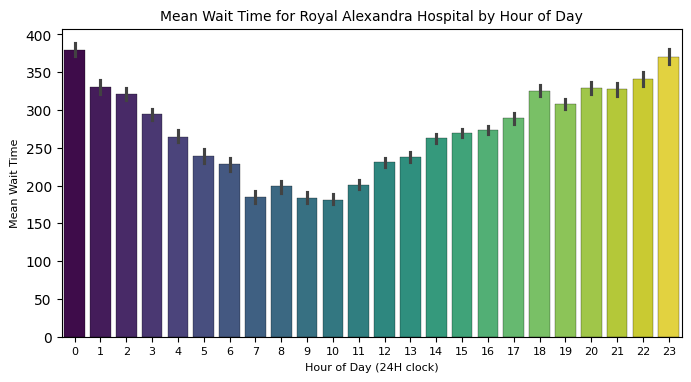

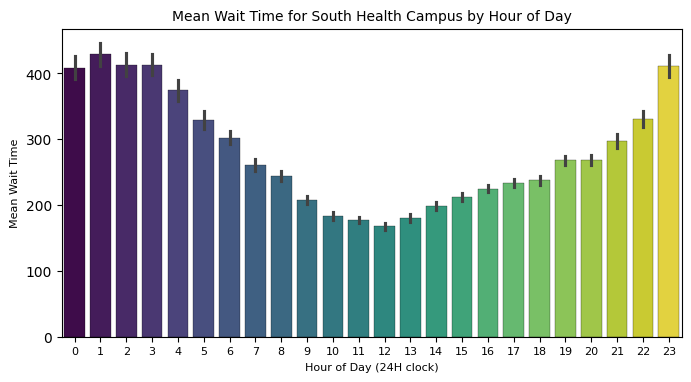

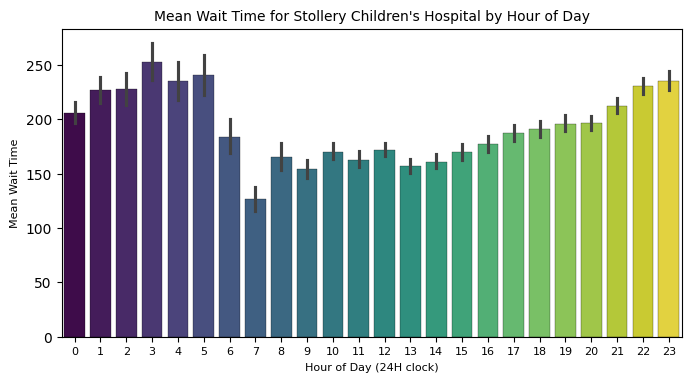

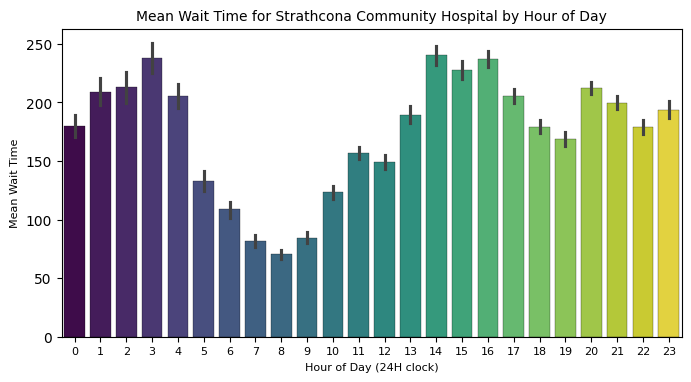

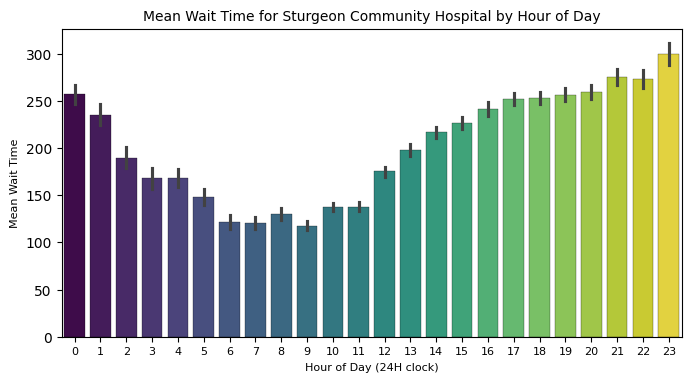

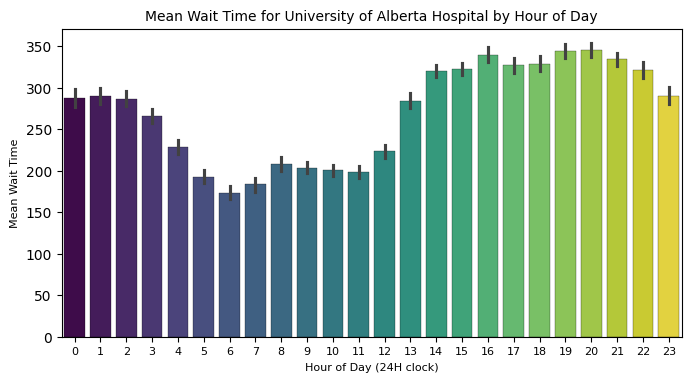

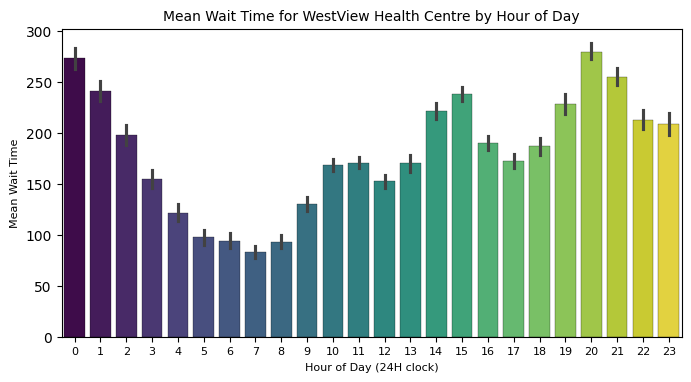

In [63]:
# Make a plot for each hospital in hospital_names:
for hospital in desired_hospitals:
    data_df = df_er[df_er['hospital'] == hospital]
    
    # Create a new subplot for each hospital
    plt.figure(figsize=(8,4))
    
    # Plot the bar graph for the current hospital
    sns.barplot(data=data_df, x='hour', y='waittime', hue='hour', palette='viridis', linewidth=0.2, edgecolor='black', legend=False)
    
    # Set title and labels
    plt.title(f'Mean Wait Time for {hospital} by Hour of Day', fontsize=10)
    plt.xlabel('Hour of Day (24H clock)', fontsize=8)
    plt.ylabel('Mean Wait Time', fontsize=8)
    plt.xticks(fontsize=8)
    # Show or save the plot as needed
    plt.show()

Plot of Hour of Day changes by Hospital as a line plot

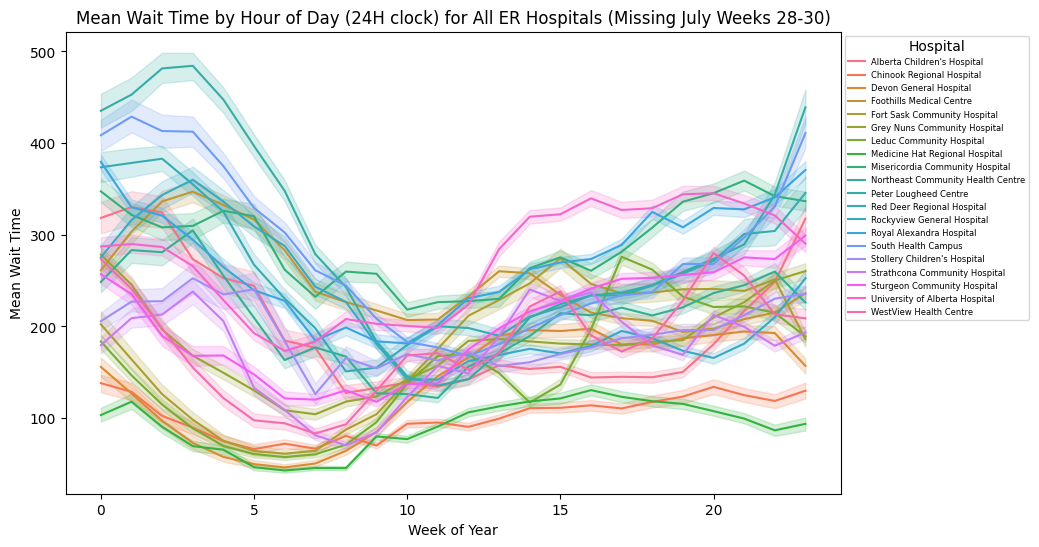

In [82]:
# Create figure and set color palette
plt.figure(figsize=(10,6));
sns.set_palette("tab10")

# Create line plot
#sns.lineplot(data=df_er, x='hour', y='waittime', errorbar='sd', hue='hospital');
sns.lineplot(data=df_er, x='hour', y='waittime', hue='hospital');

# Set title and labels
plt.title('Mean Wait Time by Hour of Day (24H clock) for All ER Hospitals (Missing July Weeks 28-30)', fontsize=12);
plt.xlabel('Week of Year', fontsize=10);
plt.ylabel('Mean Wait Time', fontsize=10);

# Set legend
plt.legend(title='Hospital', loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6);

By Period of Day

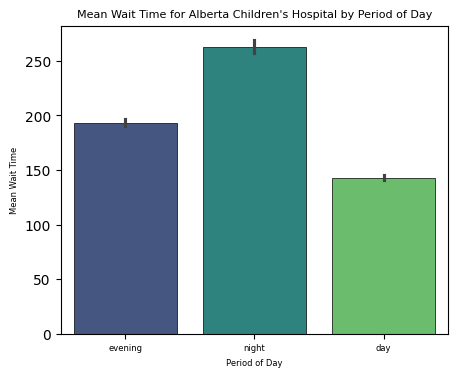

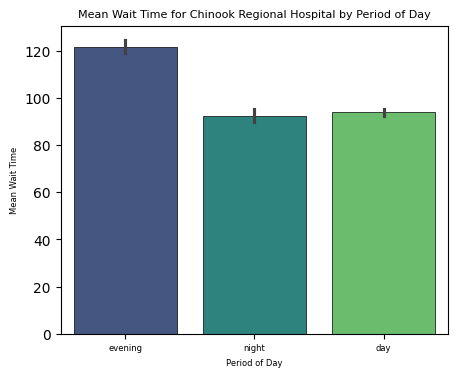

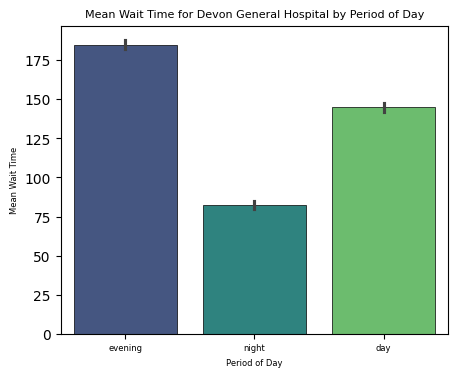

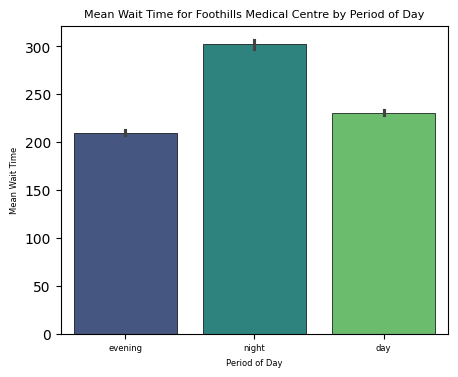

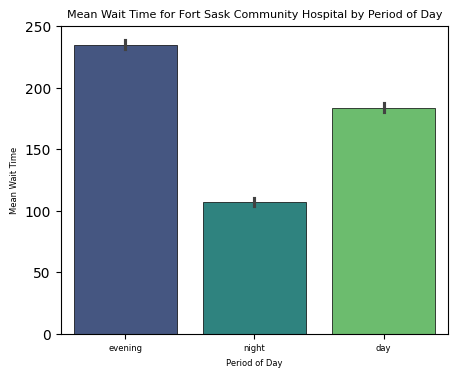

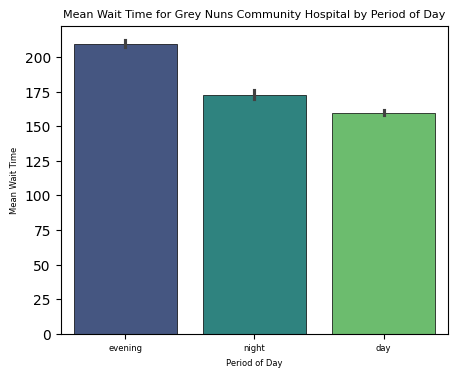

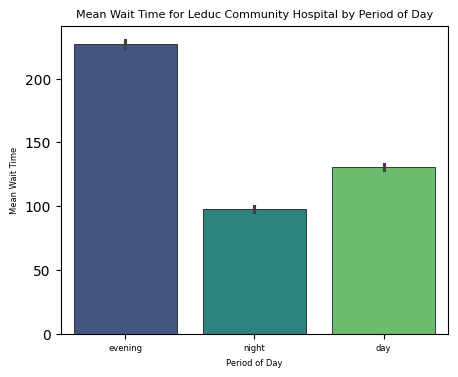

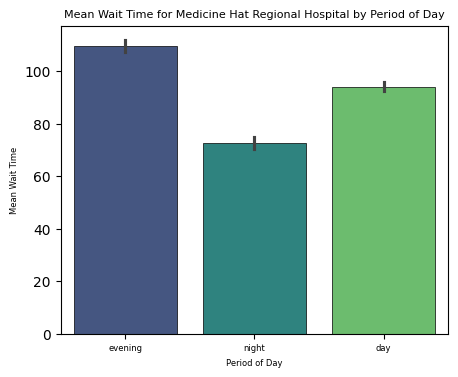

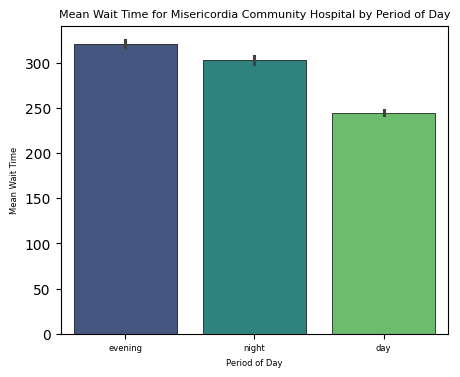

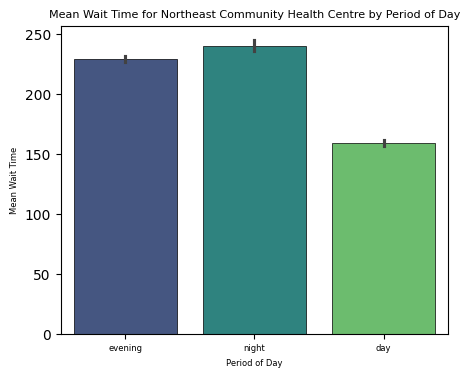

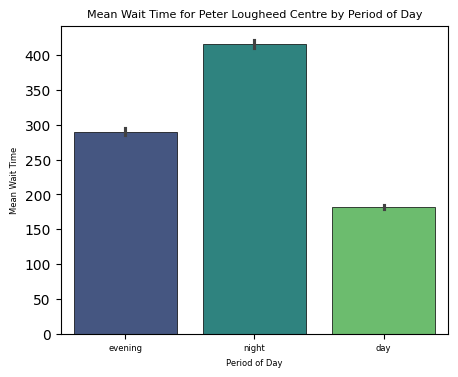

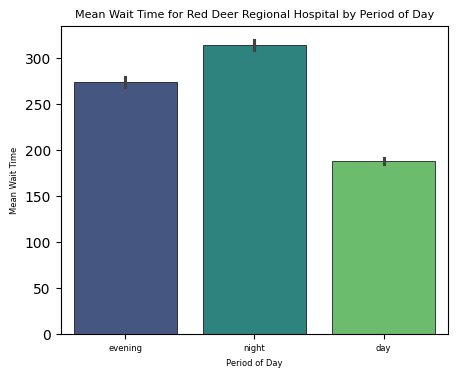

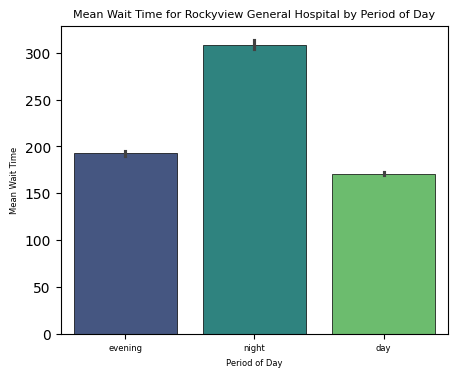

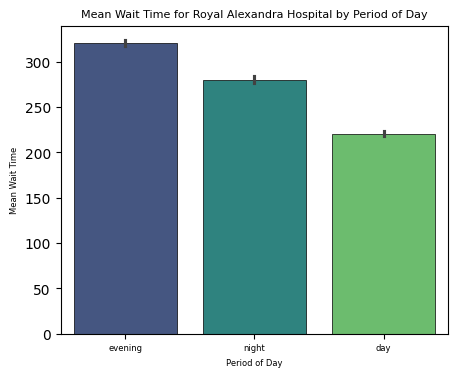

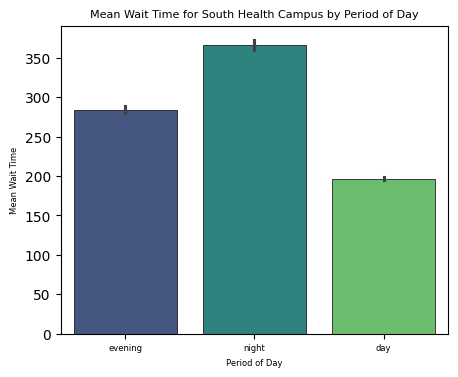

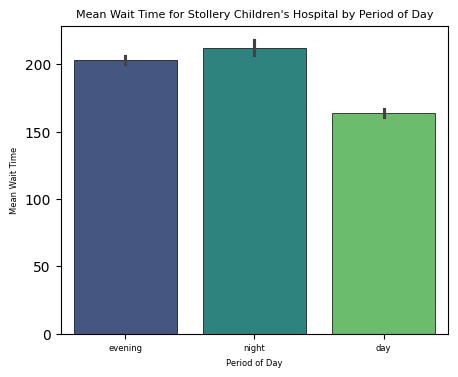

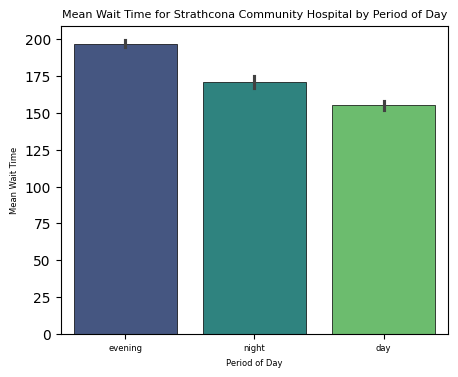

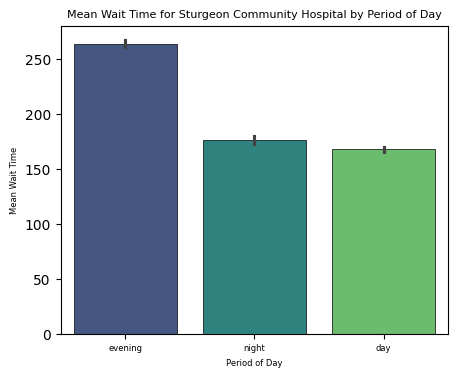

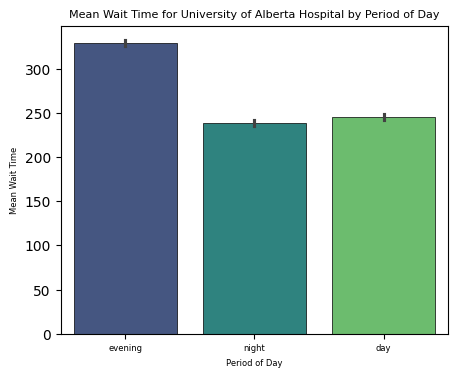

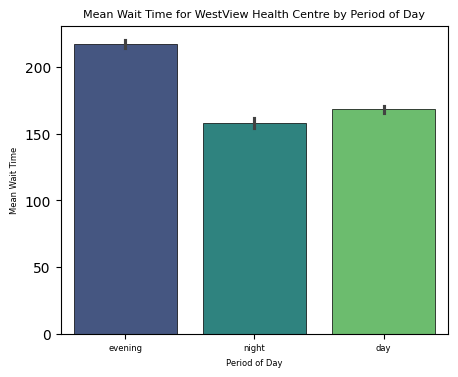

In [83]:
# Make a plot for each hospital in hospital_names:
for hospital in desired_hospitals:
    data_df = df_er[df_er['hospital'] == hospital]
    
    # Create a new subplot for each hospital
    plt.figure(figsize=(5,4))
    
    # Plot the bar graph for the current hospital
    sns.barplot(data=data_df, x='dayperiod', y='waittime', hue='dayperiod', palette='viridis', linewidth=0.5, edgecolor='black')
    
    # Set title and labels
    plt.title(f'Mean Wait Time for {hospital} by Period of Day', fontsize=8)
    plt.xlabel('Period of Day', fontsize=6)
    plt.ylabel('Mean Wait Time', fontsize=6)
    plt.xticks(fontsize=6)
    # Show or save the plot as needed
    plt.show()

Plot of Period of Day Changes by Hospital as a line plot

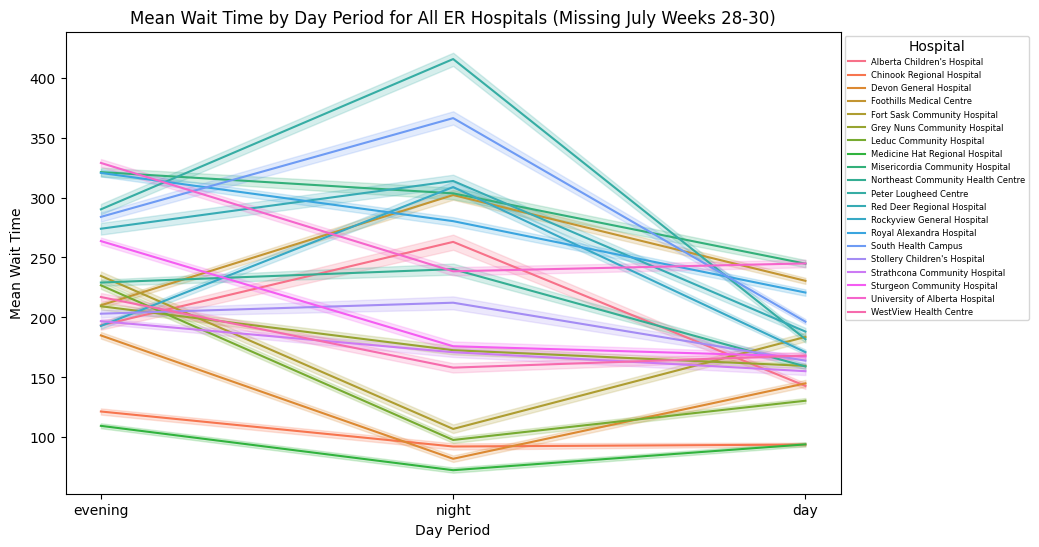

In [160]:
# Create figure and set color palette
plt.figure(figsize=(10,6));
sns.set_palette("tab10")

# Create line plot
#sns.lineplot(data=df_er, x='dayperiod', y='waittime', errorbar='sd', hue='hospital');
sns.lineplot(data=df_er, x='dayperiod', y='waittime', hue='hospital', errorbar='ci');

# Set title and labels
plt.title('Mean Wait Time by Day Period for All ER Hospitals (Missing July Weeks 28-30)', fontsize=12);
plt.xlabel('Day Period', fontsize=10);
plt.ylabel('Mean Wait Time', fontsize=10);

# Set legend
plt.legend(title='Hospital', loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6);

# Statistical Tests

## Homogeneity in variances
Levene's test
- Use Levene's because it is less sensitive to departures from normality or outliers, than Barlett's
- We know the waittimes are not normally distributed, from Kolmogorov-Smirnov test above

In [85]:
# Check for equal variances - Levene's
levenes_data = [raw_er[hospital].dropna().values for hospital in desired_hospitals]
stat, p = stats.levene(*levenes_data)
print (f"Levene's test p-value={p}.  Variances are {'**NOT** ' if round(p, 2) < 0.05 else ''}equal")

Levene's test p-value=0.0.  Variances are **NOT** equal


## Normality

Kolmorogov-Smirnov test for high N
* Use Kolmorogov-Smirnov test because of the high N sample


Across all ER hospitals

In [87]:
# Kolmorogov-Smirnov test for normality, for high N
#print (f"Kolmorogov-Smirnov test for normality, for high N:  Test waittime across all ER hospitals:\n")
stat, p = stats.kstest(df_er['waittime'], 'norm')
#print (f"Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value={p}.  Data are{'**NOT**' if round(p, 2) < 0.05 else ''} normally distributed.")
print("Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value={:>5}.  Data are{:>13} normally distributed.".format(p, '**NOT**' if round(p, 2) < 0.05 else ''))

Wait Times across all ER hospitals: Kolmogorov-Smirnov test p-value=  0.0.  Data are      **NOT** normally distributed.


waittime at each ER hospital

In [89]:
# Kologorov-Smirnov test for normality, for each hospital that has any waittime data
print (f"Kolmorogov-Smirnov test for normality, for high N:  Test for each ER hospital:\n")
for hosp in desired_hospitals:
    stat, p = stats.kstest(df_er[df_er['hospital'] == hosp]['waittime'], 'norm')
    #print (f"{hosp}: Kolmogorov-Smirnov test p-value={p}.  Data are{'**NOT**' if round(p, 2) < 0.05 else ''} normally distributed.")
    print("{:<40}: Kolmogorov-Smirnov test p-value={:>5}.  Data are {:>7} normally distributed.".format(hosp, p, '**NOT**' if round(p, 2) < 0.05 else ''))

Kolmorogov-Smirnov test for normality, for high N:  Test for each ER hospital:

Alberta Children's Hospital             : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Chinook Regional Hospital               : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Devon General Hospital                  : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Foothills Medical Centre                : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Fort Sask Community Hospital            : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Grey Nuns Community Hospital            : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Leduc Community Hospital                : Kolmogorov-Smirnov test p-value=  0.0.  Data are **NOT** normally distributed.
Medicine Hat Regional Hospital          : Kolmogorov-Smirnov test p-value

Finding:  Waittime data are neither normally distributed nor equal variance.  Therefore, we will use non-parametric tests.

# Comparing mean waittimes between hospitals. city, citytype, dayofweek, hour, dayperiod, weekofyear

## Between Hospitals

Welch's ANOVA to compare waittimes between hospitals

In [91]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='hospital', data=df_er)
aov

Source  ddof1         ddof2            F  p-unc       np2
0  hospital     19  66992.179985  4108.946789    0.0  0.230686

#### Initial Conclusion:
- Hospital Wait Times in ERs are not normally distributed.  (Used Kolmogorov-Smirnov instead of Shapiro-Wilks, but both indicated p < 0.05)
- Hospital Wait Times in ERs do not have equal variances between hospitals.  (Shown by Levene's)
    - Therefore, use Welch's ANOVA
- There are statistically significant differences in wait times among the hospitals.  (Concluded by p < 0.05 in Welch's ANOVA)

### Next:  Must do ad-hoc tests to see which means differ from each other.

In [92]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='hospital')

# Print the post-hoc results
posthoc_result

A                                  B  \
0          Alberta Children's Hospital          Chinook Regional Hospital   
1          Alberta Children's Hospital             Devon General Hospital   
2          Alberta Children's Hospital           Foothills Medical Centre   
3          Alberta Children's Hospital       Fort Sask Community Hospital   
4          Alberta Children's Hospital       Grey Nuns Community Hospital   
5          Alberta Children's Hospital           Leduc Community Hospital   
6          Alberta Children's Hospital     Medicine Hat Regional Hospital   
7          Alberta Children's Hospital    Misericordia Community Hospital   
8          Alberta Children's Hospital  Northeast Community Health Centre   
9          Alberta Children's Hospital              Peter Lougheed Centre   
10         Alberta Children's Hospital         Red Deer Regional Hospital   
11         Alberta Children's Hospital         Rockyview General Hospital   
12         Alberta Children's Hospital           Royal Alexandra Hospital   
13         Alberta Children's Hospital                South Health Campus   
14         Alberta Children's Hospital       Stollery Children's Hospital   
15         Alberta Children's Hospital      Strathcona Community Hospital   
16         Alberta Children's Hospital        Sturgeon Community Hospital   
17         Alberta Children's Hospital     University of Alberta Hospital   
18         Alberta Children's Hospital             WestView Health Centre   
19           Chinook Regional Hospital             Devon General Hospital   
20           Chinook Regional Hospital           Foothills Medical Centre   
21           Chinook Regional Hospital       Fort Sask Community Hospital   
22           Chinook Regional Hospital       Grey Nuns Community Hospital   
23           Chinook Regional Hospital           Leduc Community Hospital   
24           Chinook Regional Hospital     Medicine Hat Regional Hospital   
25           Chinook Regional Hospital    Misericordia Community Hospital   
26           Chinook Regional Hospital  Northeast Community Health Centre   
27           Chinook Regional Hospital              Peter Lougheed Centre   
28           Chinook Regional Hospital         Red Deer Regional Hospital   
29           Chinook Regional Hospital         Rockyview General Hospital   
30           Chinook Regional Hospital           Royal Alexandra Hospital   
31           Chinook Regional Hospital                South Health Campus   
32           Chinook Regional Hospital       Stollery Children's Hospital   
33           Chinook Regional Hospital      Strathcona Community Hospital   
34           Chinook Regional Hospital        Sturgeon Community Hospital   
35           Chinook Regional Hospital     University of Alberta Hospital   
36           Chinook Regional Hospital             WestView Health Centre   
37              Devon General Hospital           Foothills Medical Centre   
38              Devon General Hospital       Fort Sask Community Hospital   
39              Devon General Hospital       Grey Nuns Community Hospital   
40              Devon General Hospital           Leduc Community Hospital   
41              Devon General Hospital     Medicine Hat Regional Hospital   
42              Devon General Hospital    Misericordia Community Hospital   
43              Devon General Hospital  Northeast Community Health Centre   
44              Devon General Hospital              Peter Lougheed Centre   
45              Devon General Hospital         Red Deer Regional Hospital   
46              Devon General Hospital         Rockyview General Hospital   
47              Devon General Hospital           Royal Alexandra Hospital   
48              Devon General Hospital                South Health Campus   
49              Devon General Hospital       Stollery Children's Hospital   
50              Devon General Hospital      Strathcona Community Hospital   
51              Devon General Hos

Questions:
* How many between-hospital mean wait time comparisons are there?
* How many of those betweeen-hospital mean wait time comparisons are statistically significantly different?

In [98]:
print(f"Number of rows in the posthoc_result: {posthoc_result.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: {posthoc_result[round(posthoc_result['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 190
Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: 185


Finding: In the 190 hospital-to-hospital pair-wise comparisons, only 5 of them do not have statistically different mean wait times.

We can conclude that the mean wait times between most hospitals (pairwise) are statistically different from one another.

Question:
* Which hospitals do not have statistically different mean wait times (across the year) from each other?

In [94]:
# What are the rows where round(pval, 2) >= 0.05?  These are the only 5 hospitals whose mean waittimes are not statistically different from each other.
posthoc_result[round(posthoc_result['pval'], 2) >= 0.05]

A                               B  \
16       Alberta Children's Hospital     Sturgeon Community Hospital   
81      Fort Sask Community Hospital   Strathcona Community Hospital   
98      Grey Nuns Community Hospital          WestView Health Centre   
125  Misericordia Community Hospital           Peter Lougheed Centre   
173         Royal Alexandra Hospital  University of Alberta Hospital   

        mean(A)     mean(B)      diff        se         T            df  \
16   199.572385  202.523309 -2.950924  1.696539 -1.739379  16958.410394   
81   175.356095  174.418536  0.937559  1.530250  0.612684  17387.400307   
98   180.614467  181.231889 -0.617422  1.320278 -0.467645  17561.980687   
125  289.894316  295.444908 -5.550592  2.066310 -2.686234  16715.982543   
173  273.938499  270.942766  2.995732  1.478679  2.025951  18202.244870   

         pval    hedges  
16   0.973780 -0.025761  
81   1.000000  0.009064  
98   1.000000 -0.006918  
125  0.438433 -0.039803  
173  0.892338  0.029971

## Between Cities

Welch's ANOVA to compare waittimes between cities

In [95]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='city', data=df_er)
aov

Source  ddof1         ddof2            F  p-unc       np2
0   city     10  44918.906291  6429.255776    0.0  0.171485

Finding:  There are statistically significant differences in wait times across cities (all hospitals in each city are taken into account).  (Concluded by p < 0.05 in Welch's ANOVA)

### Next:  Must do ad-hoc tests to see which city means differ from each other.

In [96]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_city = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='city')

# Print the post-hoc results
posthoc_result_city

A                  B     mean(A)     mean(B)        diff  \
0             Calgary              Devon  249.631922  137.568881  112.063042   
1             Calgary           Edmonton  249.631922  236.327697   13.304225   
2             Calgary  Fort Saskatchewan  249.631922  175.356095   74.275827   
3             Calgary              Leduc  249.631922  151.941125   97.690797   
4             Calgary         Lethbridge  249.631922  102.804126  146.827796   
5             Calgary       Medicine Hat  249.631922   92.503063  157.128860   
6             Calgary           Red Deer  249.631922  258.548776   -8.916854   
7             Calgary      Sherwood Park  249.631922  174.418536   75.213386   
8             Calgary         St. Albert  249.631922  202.523309   47.108613   
9             Calgary        Stony Plain  249.631922  181.231889   68.400034   
10              Devon           Edmonton  137.568881  236.327697  -98.758816   
11              Devon  Fort Saskatchewan  137.568881  175.356095  -37.787215   
12              Devon              Leduc  137.568881  151.941125  -14.372244   
13              Devon         Lethbridge  137.568881  102.804126   34.764755   
14              Devon       Medicine Hat  137.568881   92.503063   45.065818   
15              Devon           Red Deer  137.568881  258.548776 -120.979896   
16              Devon      Sherwood Park  137.568881  174.418536  -36.849655   
17              Devon         St. Albert  137.568881  202.523309  -64.954429   
18              Devon        Stony Plain  137.568881  181.231889  -43.663008   
19           Edmonton  Fort Saskatchewan  236.327697  175.356095   60.971601   
20           Edmonton              Leduc  236.327697  151.941125   84.386572   
21           Edmonton         Lethbridge  236.327697  102.804126  133.523571   
22           Edmonton       Medicine Hat  236.327697   92.503063  143.824634   
23           Edmonton           Red Deer  236.327697  258.548776  -22.221080   
24           Edmonton      Sherwood Park  236.327697  174.418536   61.909161   
25           Edmonton         St. Albert  236.327697  202.523309   33.804388   
26           Edmonton        Stony Plain  236.327697  181.231889   55.095808   
27  Fort Saskatchewan              Leduc  175.356095  151.941125   23.414970   
28  Fort Saskatchewan         Lethbridge  175.356095  102.804126   72.551969   
29  Fort Saskatchewan       Medicine Hat  175.356095   92.503063   82.853033   
30  Fort Saskatchewan           Red Deer  175.356095  258.548776  -83.192681   
31  Fort Saskatchewan      Sherwood Park  175.356095  174.418536    0.937559   
32  Fort Saskatchewan         St. Albert  175.356095  202.523309  -27.167214   
33  Fort Saskatchewan        Stony Plain  175.356095  181.231889   -5.875793   
34              Leduc         Lethbridge  151.941125  102.804126   49.136999   
35              Leduc       Medicine Hat  151.941125   92.503063   59.438062   
36              Leduc           Red Deer  151.941125  258.548776 -106.607652   
37              Leduc      Sherwood Park  151.941125  174.418536  -22.477411   
38              Leduc         St. Albert  151.941125  202.523309  -50.582184   
39              Leduc        Stony Plain  151.941125  181.231889  -29.290764   
40         Lethbridge       Medicine Hat  102.804126   92.503063   10.301063   
41         Lethbridge           Red Deer  102.804126  258.548776 -155.744650   
42         Lethbridge      Sherwood Park  102.804126  174.418536  -71.614410   
43         Lethbridge         St. Albert  102.804126  202.523309  -99.719183   
44         Lethbridge        Stony Plain  102.804126  181.231889  -78.427763   
45       Medicine Hat           Red Deer   92.503063  258.548776 -166.045714   
46       Medicine Hat      Sherwood Park   92.503063  174.418536  -81.915473   
47       Medicine Hat         St. Albert   92.503063  202.523309 -110.020247   
48       Medicine Hat        Stony Plain   92.503063  181.231889  -88.728826   
49           Red Dee

Questions:
* How many between-hospital mean wait time comparisons are there?
* How many of those betweeen-hospital mean wait time comparisons are statistically significantly different?

In [99]:
print(f"Number of rows in the posthoc_result: {posthoc_result_city.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: {posthoc_result_city[round(posthoc_result_city['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 55
Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: 54


Finding: In the 55 city-to-city pair-wise comparisons, only 1 of them do not have statistically different mean wait times.

We can conclude that the mean wait times between most cities (pair-wise) are statistically different from one another.

Question:
* Which pairwise cities do not have statistically different mean wait times (across hospitals, across the year) from each other?

In [100]:
# What are the rows where round(pval, 2) >= 0.05?  This is the 1 city pairs whose mean waittimes are not statistically different from each other.
posthoc_result_city[round(posthoc_result_city['pval'], 2) >= 0.05]

A              B     mean(A)     mean(B)      diff  \
31  Fort Saskatchewan  Sherwood Park  175.356095  174.418536  0.937559   

         se         T            df      pval    hedges  
31  1.53025  0.612684  17387.400307  0.999944  0.009064

# Between City Types

Welch's ANOVA to compare waittimes across all city types

In [102]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='citytype', data=df_er)
aov

Source  ddof1         ddof2             F  p-unc       np2
0  citytype      2  72020.721741  16195.796477    0.0  0.136083

Finding:  There are statistically significant differences in wait times across cities (all hospitals in each city are taken into account).  (Concluded by p < 0.05 in Welch's ANOVA)

Games-Howell to do pair-wise comparisons

In [103]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_citytype = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='citytype')

# Print the post-hoc results
posthoc_result_citytype

A      B     mean(A)     mean(B)       diff        se           T  \
0   peri  rural  145.507558  164.717965 -19.210407  0.762481  -25.194610   
1   peri  urban  145.507558  243.710885 -98.203327  0.573384 -171.269827   
2  rural  urban  164.717965  243.710885 -78.992920  0.726378 -108.749015   

              df          pval    hedges  
0   53114.935417  0.000000e+00 -0.198106  
1  109767.234376  0.000000e+00 -0.855550  
2   48632.493107  6.829892e-11 -0.663384

In [104]:
print(f"Number of rows in the posthoc_result: {posthoc_result_citytype.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05 and the means are statistically different from one another: {posthoc_result_citytype[round(posthoc_result_citytype['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 3
Number of rows in the posthoc_result where round(pval, 2) < 0.05 and the means are statistically different from one another: 3


Finding:  All city types have statistically different mean wait times from each other.

As the below shows, there are no pair-wise city type comparisons for which the means are statistically the same.

In [369]:
# What are the rows where round(pval, 2) >= 0.05?  These are no city type pairs whose mean waittimes are not statistically different from each other.
posthoc_result_citytype[round(posthoc_result_citytype['pval'], 2) >= 0.05]

Empty DataFrame
Columns: [A, B, mean(A), mean(B), diff, se, T, df, pval, hedges]
Index: []

# Between Days of Week

Welch's ANOVA to compare waittimes across all days of week

In [105]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='dayofweek', data=df_er)
aov

Source  ddof1         ddof2          F  p-unc       np2
0  dayofweek      6  80827.236812  288.59409    0.0  0.009363

Finding:  There are statistically significant differences in wait times across days of week (all hospitals are taken into account).  (Concluded by p < 0.05 in Welch's ANOVA)

Games-Howell to do pair-wise comparisons

In [106]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_dayofweek = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='dayofweek')

# Print the post-hoc results
posthoc_result_dayofweek

A          B     mean(A)     mean(B)       diff        se  \
0     Friday     Monday  206.094952  217.165409 -11.070457  1.062881   
1     Friday   Saturday  206.094952  191.991099  14.103852  1.069029   
2     Friday     Sunday  206.094952  191.989051  14.105901  1.023147   
3     Friday   Thursday  206.094952  205.851327   0.243625  1.073766   
4     Friday    Tuesday  206.094952  226.601708 -20.506756  1.101361   
5     Friday  Wednesday  206.094952  212.512740  -6.417788  1.080248   
6     Monday   Saturday  217.165409  191.991099  25.174309  1.054999   
7     Monday     Sunday  217.165409  191.989051  25.176358  1.008479   
8     Monday   Thursday  217.165409  205.851327  11.314082  1.059798   
9     Monday    Tuesday  217.165409  226.601708  -9.436299  1.087748   
10    Monday  Wednesday  217.165409  212.512740   4.652669  1.066366   
11  Saturday     Sunday  191.991099  191.989051   0.002048  1.014957   
12  Saturday   Thursday  191.991099  205.851327 -13.860228  1.065964   
13  Saturday    Tuesday  191.991099  226.601708 -34.610608  1.093756   
14  Saturday  Wednesday  191.991099  212.512740 -20.521641  1.072494   
15    Sunday   Thursday  191.989051  205.851327 -13.862276  1.019944   
16    Sunday    Tuesday  191.989051  226.601708 -34.612657  1.048957   
17    Sunday  Wednesday  191.989051  212.512740 -20.523689  1.026767   
18  Thursday    Tuesday  205.851327  226.601708 -20.750381  1.098386   
19  Thursday  Wednesday  205.851327  212.512740  -6.661413  1.077215   
20   Tuesday  Wednesday  226.601708  212.512740  14.088968  1.104724   

            T            df          pval    hedges  
0  -10.415519  51693.654542  0.000000e+00 -0.091584  
1   13.193142  51596.851809  0.000000e+00  0.116146  
2   13.786775  51219.754119  0.000000e+00  0.121127  
3    0.226888  51462.101127  9.999887e-01  0.002000  
4  -18.619469  51810.224533  0.000000e+00 -0.163431  
5   -5.941030  52180.155893  5.969394e-08 -0.052006  
6   23.861928  51800.400332  0.000000e+00  0.209663  
7   24.964683  51722.920642  0.000000e+00  0.218806  
8   10.675695  51628.863575  0.000000e+00  0.093942  
9   -8.675079  51846.655316  0.000000e+00 -0.076007  
10   4.363108  52352.051147  2.589756e-04  0.038114  
11   0.002018  51459.963324  1.000000e+00  0.000018  
12 -13.002528  51525.844124  0.000000e+00 -0.114554  
13 -31.643802  51805.251782  3.453016e-12 -0.277561  
14 -19.134504  52246.757214  0.000000e+00 -0.167361  
15 -13.591209  51190.474176  0.000000e+00 -0.119510  
16 -32.997226  51066.302839  0.000000e+00 -0.288755  
17 -19.988653  51922.234216  0.000000e+00 -0.174303  
18 -18.891698  51716.302876  0.000000e+00 -0.165923  
19  -6.183920  52104.837603  1.319649e-08 -0.054166  
20  12.753377  52426.097329  0.000000e+00  0.111313

Questions:
* How many day-to-day mean wait time comparisons are there?
* How many of those between-day mean wait time comparisons are statistically significantly different?

In [107]:
print(f"Number of rows in the posthoc_result: {posthoc_result_dayofweek.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: {posthoc_result_dayofweek[round(posthoc_result_dayofweek['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 21
Number of rows in the posthoc_result where round(pval, 2) < 0.05 and mean waittimes are statistically different: 19


Finding: In the 21 day-to-day pair-wise comparisons, only 2 of them do not have statistically different mean wait times.

Question:
* Which days of the week do not have statistically different mean wait times (across the year) from each other?

In [378]:
# What are the rows where round(pval, 2) >= 0.05?  These are 2 day-to-day pairs whose mean waittimes are not statistically different from each other.
posthoc_result_dayofweek[round(posthoc_result_dayofweek['pval'], 2) >= 0.05]

A         B     mean(A)     mean(B)      diff        se         T  \
3     Friday  Thursday  206.094952  205.851327  0.243625  1.073766  0.226888   
11  Saturday    Sunday  191.991099  191.989051  0.002048  1.014957  0.002018   

              df      pval    hedges  
3   51462.101127  0.999989  0.002000  
11  51459.963324  1.000000  0.000018

Finding:  In general, the mean wait times across all hospitals do not differ significantly from each other on Thursday and Friday, and on the weekend (Saturday and Sunday).and

From a statistical perspective, across all hospitals, the mean wait times on Thursday and Friday are the same, and on Saturday and Sunday are the same.

# Between Hour of Day

Welch's ANOVA to compare waittimes across all hours of the day

Please note:  These t-tests are done simply for completeness' sake.  The tests start to break down here because they are doing pairwise comparisons across 24 hours.  They are not that meaningful also because this is over all ER hospitals over all cities.

In [379]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='hour', data=df_er)
aov

Source  ddof1         ddof2            F  p-unc       np2
0   hour     23  65854.053827  1035.684799    0.0  0.101037

Games-Howell to do pair-wise comparisons

In [381]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_hour = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='hour')

# Print the post-hoc results
posthoc_result_hour

A   B     mean(A)     mean(B)        diff        se          T  \
0     0   1  266.345575  264.423373    1.922201  2.500264   0.768799   
1     0   2  266.345575  252.713443   13.632131  2.566614   5.311328   
2     0   3  266.345575  241.378658   24.966917  2.586807   9.651634   
3     0   4  266.345575  219.384018   46.961556  2.499988  18.784715   
4     0   5  266.345575  193.763137   72.582438  2.419508  29.998842   
5     0   6  266.345575  168.427204   97.918371  2.281283  42.922501   
6     0   7  266.345575  149.198008  117.147567  2.150844  54.465848   
7     0   8  266.345575  149.065546  117.280029  2.076948  56.467473   
8     0   9  266.345575  144.670601  121.674974  1.969647  61.775022   
9     0  10  266.345575  151.520407  114.825168  1.910546  60.100713   
10    0  11  266.345575  160.322615  106.022960  1.902830  55.718568   
11    0  12  266.345575  173.091779   93.253795  1.920680  48.552490   
12    0  13  266.345575  186.649869   79.695705  1.957332  40.716497   
13    0  14  266.345575  202.705650   63.639924  1.983954  32.077320   
14    0  15  266.345575  209.226465   57.119110  1.990112  28.701459   
15    0  16  266.345575  211.420134   54.925441  1.995247  27.528137   
16    0  17  266.345575  214.753143   51.592432  2.016017  25.591267   
17    0  18  266.345575  217.516562   48.829012  2.038880  23.948941   
18    0  19  266.345575  222.573786   43.771789  2.065186  21.195087   
19    0  20  266.345575  233.664037   32.681537  2.079072  15.719288   
20    0  21  266.345575  240.953341   25.392233  2.128296  11.930779   
21    0  22  266.345575  246.998159   19.347415  2.197259   8.805249   
22    0  23  266.345575  259.647771    6.697804  2.375657   2.819348   
23    1   2  264.423373  252.713443   11.709930  2.621019   4.467701   
24    1   3  264.423373  241.378658   23.044715  2.640796   8.726427   
25    1   4  264.423373  219.384018   45.039355  2.555811  17.622332   
26    1   5  264.423373  193.763137   70.660236  2.477146  28.524858   
27    1   6  264.423373  168.427204   95.996169  2.342325  40.983289   
28    1   7  264.423373  149.198008  115.225365  2.215483  52.009140   
29    1   8  264.423373  149.065546  115.357828  2.143816  53.809571   
30    1   9  264.423373  144.670601  119.752773  2.040035  58.701341   
31    1  10  264.423373  151.520407  112.902966  1.983033  56.934497   
32    1  11  264.423373  160.322615  104.100759  1.975600  52.693241   
33    1  12  264.423373  173.091779   91.331594  1.992798  45.830830   
34    1  13  264.423373  186.649869   77.773504  2.028147  38.347067   
35    1  14  264.423373  202.705650   61.717723  2.053852  30.049749   
36    1  15  264.423373  209.226465   55.196908  2.059800  26.797212   
37    1  16  264.423373  211.420134   53.003239  2.064763  25.670379   
38    1  17  264.423373  214.753143   49.670230  2.084840  23.824480   
39    1  18  264.423373  217.516562   46.906811  2.106956  22.262833   
40    1  19  264.423373  222.573786   41.849588  2.132422  19.625375   
41    1  20  264.423373  233.664037   30.759336  2.145874  14.334176   
42    1  21  264.423373  240.953341   23.470032  2.193599  10.699325   
43    1  22  264.423373  246.998159   17.425214  2.260571   7.708324   
44    1  23  264.423373  259.647771    4.775603  2.434333   1.961770   
45    2   3  252.713443  241.378658   11.334786  2.703700   4.192324   
46    2   4  252.713443  219.384018   33.329425  2.620755  12.717487   
47    2   5  252.713443  193.763137   58.950306  2.544099  23.171388   
48    2   6  252.713443  168.427204   84.286239  2.413021  34.929751   
49    2   7  252.713443  149.198008  103.515435  2.290099  45.201296   
50    2   8  252.713443  149.065546  103.647898  2.220841  46.670558   
51    2   9  252.713443  144.670601  108.042843  2.120832  50.943607   
52    2  10  252.713443  151.520407  101.193036  2.066061  48.978737   
53    2  11  252.713443  160.322615   92.390829  2.058928  44.873279   
54    2  12  252.713443  173.091779   79.62166

In [382]:
print(f"Number of rows in the posthoc_result: {posthoc_result_hour.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05: {posthoc_result_hour[round(posthoc_result_hour['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 276
Number of rows in the posthoc_result where round(pval, 2) < 0.05: 254


In [383]:
# What are the rows where round(pval, 2) >= 0.05?  These are the hour-to-hour pairs whose mean waittimes are not statistically different from each other.
posthoc_result_hour[round(posthoc_result_hour['pval'], 2) >= 0.05]

A   B     mean(A)     mean(B)      diff        se         T  \
0     0   1  266.345575  264.423373  1.922201  2.500264  0.768799   
22    0  23  266.345575  259.647771  6.697804  2.375657  2.819348   
44    1  23  264.423373  259.647771  4.775603  2.434333  1.961770   
64    2  22  252.713443  246.998159  5.715284  2.333746  2.448975   
65    2  23  252.713443  259.647771 -6.934327  2.502432 -2.771035   
82    3  20  241.378658  233.664037  7.714620  2.246113  3.434653   
83    3  21  241.378658  240.953341  0.425316  2.291752  0.185586   
84    3  22  241.378658  246.998159 -5.619502  2.355935 -2.385253   
98    4  17  219.384018  214.753143  4.630875  2.084508  2.221567   
99    4  18  219.384018  217.516562  1.867456  2.106628  0.886467   
100   4  19  219.384018  222.573786 -3.189767  2.132098 -1.496070   
128   6  12  168.427204  173.091779 -4.664575  1.710022 -2.727787   
140   7   8  149.198008  149.065546  0.132462  1.723589  0.076853   
141   7   9  149.198008  144.670601  4.527407  1.592655  2.842679   
142   7  10  149.198008  151.520407 -2.322399  1.518956 -1.528944   
156   8   9  149.065546  144.670601  4.394945  1.491353  2.946951   
157   8  10  149.065546  151.520407 -2.454861  1.412378 -1.738105   
240  15  16  209.226465  211.420134 -2.193669  1.404446 -1.561947   
248  16  17  211.420134  214.753143 -3.333009  1.440919 -2.313114   
255  17  18  214.753143  217.516562 -2.763419  1.500755 -1.841352   
261  18  19  217.516562  222.573786 -5.057223  1.566184 -3.229009   
273  21  22  240.953341  246.998159 -6.044818  1.840789 -3.283819   

               df      pval    hedges  
0    15063.586078  1.000000  0.012514  
22   15116.901612  0.422056  0.045780  
44   14958.606092  0.956670  0.031908  
64   13563.559840  0.714628  0.040023  
65   14685.379065  0.459567 -0.045215  
82   12258.155574  0.095087  0.056230  
83   12773.593989  1.000000  0.003038  
84   13443.289784  0.760200 -0.039010  
98   11948.770541  0.859816  0.036346  
99   12257.754532  1.000000  0.014497  
100  12570.840197  0.998682 -0.024465  
128  11871.552446  0.493909 -0.044485  
140  14910.490275  1.000000  0.001252  
141  13897.491973  0.404355  0.046264  
142  12782.429471  0.998182 -0.024911  
156  14591.727567  0.329275  0.047883  
157  13604.397741  0.989457 -0.028278  
240  15210.822429  0.997523 -0.025325  
248  15229.820857  0.807527 -0.037452  
255  15278.677654  0.978655 -0.029765  
261  15203.914338  0.169433 -0.052316  
273  15077.446879  0.146320 -0.053274

# Between Day Period

Welch's ANOVA to compare waittimes across all day periods

In [108]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='dayperiod', data=df_er)
aov

Source  ddof1          ddof2            F  p-unc       np2
0  dayperiod      2  115224.162973  6239.127418    0.0  0.043716

Games-Howell to do pair-wise comparisons

In [109]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_dayperiod = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='dayperiod')

# Print the post-hoc results
posthoc_result_dayperiod

A        B     mean(A)     mean(B)       diff        se           T  \
0      day  evening  172.191948  230.920364 -58.728417  0.555452 -105.730893   
1      day    night  172.191948  219.423147 -47.231199  0.717722  -65.807058   
2  evening    night  230.920364  219.423147  11.497218  0.766139   15.006692   

              df          pval    hedges  
0  115670.454864  0.000000e+00 -0.605534  
1   93066.762290  5.860001e-11 -0.379806  
2  107208.096645  0.000000e+00  0.086486

In [112]:
print(f"Number of rows in the posthoc_result: {posthoc_result_dayperiod.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05: {posthoc_result_dayperiod[round(posthoc_result_dayperiod['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 3
Number of rows in the posthoc_result where round(pval, 2) < 0.05: 3


In [113]:
# What are the rows where round(pval, 2) >= 0.05?  There are no day period pairs whose mean waittimes are not statistically different from each other.
posthoc_result_dayperiod[round(posthoc_result_dayperiod['pval'], 2) >= 0.05]

Empty DataFrame
Columns: [A, B, mean(A), mean(B), diff, se, T, df, pval, hedges]
Index: []

Finding:  There are statistically different means between the 3 day periods (morning, afternoon, evening) for all hospitals.

# Between Week of Year

Welch's ANOVA to compare waittimes across all weeks of the year

Please note:  These t-tests are done simply for completeness' sake.  The tests start to break down here because they are doing pairwise comparisons across 52 weeks, resulting in a **lot** of combinations.  They are not that meaningful also because this is over all ER hospitals over all cities.

In [110]:
# Welch's ANOVA for non-normal, hereoscedastic data
aov = pg.welch_anova(dv='waittime', between='weekofyear', data=df_er)
aov

Source  ddof1         ddof2           F  p-unc       np2
0  weekofyear     48  58130.257979  158.860435    0.0  0.035761

Games-Howell to do pair-wise comparisons

In [111]:
# Credit to ChatGPT for suggesting to use Games-Howell post-hoc test for groups with unequal variances.

# Perform Games-Howell post-hoc test
posthoc_result_weekofyear = pg.pairwise_gameshowell(data=df_er, dv='waittime', between='weekofyear')

# Print the post-hoc results
posthoc_result_weekofyear

c:\Users\raref\.conda\envs\bootcamp_env\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


A   B     mean(A)     mean(B)        diff        se          T  \
0      1   2  236.875150  205.691317   31.183832  3.286924   9.487239   
1      1   3  236.875150  179.534152   57.340998  3.112268  18.424185   
2      1   4  236.875150  168.944904   67.930246  3.150160  21.564064   
3      1   5  236.875150  160.865236   76.009914  3.043509  24.974434   
4      1   6  236.875150  188.279167   48.595983  3.128948  15.531091   
5      1   7  236.875150  191.787202   45.087947  3.191089  14.129329   
6      1   8  236.875150  162.724251   74.150898  2.972226  24.947936   
7      1   9  236.875150  205.509845   31.365305  3.250910   9.648160   
8      1  10  236.875150  175.513489   61.361660  3.144273  19.515372   
9      1  11  236.875150  200.728708   36.146442  3.162849  11.428444   
10     1  12  236.875150  192.383036   44.492114  3.146051  14.142210   
11     1  13  236.875150  183.718778   53.156372  3.210235  16.558405   
12     1  14  236.875150  181.081250   55.793900  3.120957  17.877177   
13     1  15  236.875150  184.261001   52.614149  3.188229  16.502626   
14     1  16  236.875150  182.108982   54.766168  3.114096  17.586536   
15     1  17  236.875150  203.128205   33.746945  3.284005  10.276156   
16     1  18  236.875150  233.105280    3.769870  3.501296   1.076707   
17     1  19  236.875150  220.630060   16.245090  3.339560   4.864441   
18     1  20  236.875150  199.284693   37.590456  3.216400  11.687123   
19     1  21  236.875150  218.615179   18.259971  3.351007   5.449099   
20     1  22  236.875150  234.642518    2.232632  3.376335   0.661259   
21     1  23  236.875150  223.593369   13.281781  3.311647   4.010627   
22     1  24  236.875150  214.060926   22.814223  3.332896   6.845165   
23     1  25  236.875150  196.427796   40.447353  3.218446  12.567355   
24     1  26  236.875150  221.429390   15.445759  3.275859   4.715026   
25     1  27  236.875150  216.444030   20.431120  4.420144   4.622274   
26     1  31  236.875150  204.768447   32.106703  3.528665   9.098824   
27     1  32  236.875150  212.086012   24.789138  3.163511   7.835957   
28     1  33  236.875150  204.532143   32.343007  3.187623  10.146435   
29     1  34  236.875150  194.787202   42.087947  3.094512  13.600833   
30     1  35  236.875150  228.396773    8.478376  3.251677   2.607386   
31     1  36  236.875150  219.869048   17.006102  3.207199   5.302478   
32     1  37  236.875150  230.288120    6.587029  3.217203   2.047440   
33     1  38  236.875150  212.828780   24.046369  3.091532   7.778140   
34     1  39  236.875150  220.929159   15.945991  2.902816   5.493284   
35     1  40  236.875150  217.947772   18.927377  2.867698   6.600198   
36     1  41  236.875150  216.157958   20.717192  2.876722   7.201665   
37     1  42  236.875150  223.744612   13.130538  3.072670   4.273332   
38     1  43  236.875150  187.412575   49.462575  3.171966  15.593663   
39     1  44  236.875150  227.234533    9.640616  3.000670   3.212821   
40     1  45  236.875150  231.240018    5.635132  2.934859   1.920069   
41     1  46  236.875150  237.461194   -0.586044  2.916323  -0.200953   
42     1  47  236.875150  241.172055   -4.296905  3.218548  -1.335045   
43     1  48  236.875150  187.932024   48.943126  3.118371  15.695094   
44     1  49  236.875150  192.544179   44.330971  3.213864  13.793667   
45     1  50  236.875150  191.855952   45.019197  3.158850  14.251767   
46     1  51  236.875150  139.172033   97.703116  2.971429  32.880846   
47     1  52  236.875150  245.984524   -9.109374  3.424928  -2.659727   
48     2   3  205.691317  179.534152   26.157165  2.854062   9.164890   
49     2   4  205.691317  168.944904   36.746414  2.895335  12.691592   
50     2   5  205.691317  160.865236   44.826082  2.778922  16.130746   
51     2   6  205.691317  188.279167   17.412151  2.872243   6.062214   
52     2   7  205.691317  191.787202   13.904115  2.939815   4.729589   
53     2   8  205.691317  162.724251   42.967066  2.700664  15.90

In [114]:
print(f"Number of rows in the posthoc_result: {posthoc_result_weekofyear.shape[0]}")
print(f"Number of rows in the posthoc_result where round(pval, 2) < 0.05: {posthoc_result_weekofyear[round(posthoc_result_weekofyear['pval'], 2) < 0.05].shape[0]}")

Number of rows in the posthoc_result: 1176
Number of rows in the posthoc_result where round(pval, 2) < 0.05: 867


Of the 1176 pair-wise combinations of "week of year", 867 of the pairs have statistically different means.

Below, we find out which of the pair-wise week of year comparisons do not have statistically different means.

In [115]:
# What are the rows where round(pval, 2) >= 0.05?  These are the pair-wise weeks whose mean waittimes are not statistically different from each other, across all hospitals.
posthoc_result_weekofyear[round(posthoc_result_weekofyear['pval'], 2) >= 0.05]

A   B     mean(A)     mean(B)       diff        se         T  \
16     1  18  236.875150  233.105280   3.769870  3.501296  1.076707   
20     1  22  236.875150  234.642518   2.232632  3.376335  0.661259   
21     1  23  236.875150  223.593369  13.281781  3.311647  4.010627   
30     1  35  236.875150  228.396773   8.478376  3.251677  2.607386   
32     1  37  236.875150  230.288120   6.587029  3.217203  2.047440   
39     1  44  236.875150  227.234533   9.640616  3.000670  3.212821   
40     1  45  236.875150  231.240018   5.635132  2.934859  1.920069   
41     1  46  236.875150  237.461194  -0.586044  2.916323 -0.200953   
42     1  47  236.875150  241.172055  -4.296905  3.218548 -1.335045   
47     1  52  236.875150  245.984524  -9.109374  3.424928 -2.659727   
54     2   9  205.691317  205.509845   0.181472  3.004643  0.060397   
56     2  11  205.691317  200.728708   4.962610  2.909136  1.705871   
62     2  17  205.691317  203.128205   2.563112  3.040419  0.843013   
65     2  20  205.691317  199.284693   6.406624  2.967269  2.159098   
69     2  24  205.691317  214.060926  -8.369609  3.093163 -2.705842   
70     2  25  205.691317  196.427796   9.263521  2.969487  3.119569   
72     2  27  205.691317  216.444030 -10.752712  4.242303 -2.534640   
73     2  31  205.691317  204.768447   0.922871  3.303171  0.279389   
74     2  32  205.691317  212.086012  -6.394695  2.909856 -2.197598   
75     2  33  205.691317  204.532143   1.159175  2.936051  0.394807   
76     2  34  205.691317  194.787202  10.904115  2.834690  3.846669   
80     2  38  205.691317  212.828780  -7.137463  2.831436 -2.520793   
95     3   4  179.534152  168.944904  10.589249  2.695424  3.928603   
97     3   6  179.534152  188.279167  -8.745014  2.670603 -3.274547   
101    3  10  179.534152  175.513489   4.020663  2.688541  1.495481   
104    3  13  179.534152  183.718778  -4.184626  2.765395 -1.513211   
105    3  14  179.534152  181.081250  -1.547098  2.661235 -0.581346   
106    3  15  179.534152  184.261001  -4.726848  2.739818 -1.725242   
107    3  16  179.534152  182.108982  -2.574830  2.653186 -0.970467   
131    3  43  179.534152  187.412575  -7.878423  2.720877 -2.895545   
136    3  48  179.534152  187.932024  -8.397872  2.658202 -3.159230   
141    4   5  168.944904  160.865236   8.079668  2.615730  3.088877   
144    4   8  168.944904  162.724251   6.220652  2.532434  2.456392   
146    4  10  168.944904  175.513489  -6.568586  2.732316 -2.404036   
188    5   8  160.865236  162.724251  -1.859016  2.398471 -0.775084   
230    6   7  188.279167  191.787202  -3.508036  2.762057 -1.270081   
235    6  12  188.279167  192.383036  -4.103869  2.709898 -1.514400   
236    6  13  188.279167  183.718778   4.560389  2.784155  1.637980   
237    6  14  188.279167  181.081250   7.197917  2.680724  2.685065   
238    6  15  188.279167  184.261001   4.018166  2.758752  1.456516   
239    6  16  188.279167  182.108982   6.170185  2.672734  2.308567   
243    6  20  188.279167  199.284693 -11.005527  2.791260 -3.942852   
248    6  25  188.279167  196.427796  -8.148630  2.793618 -2.916873   
254    6  34  188.279167  194.787202  -6.508036  2.649890 -2.455965   
263    6  43  188.279167  187.412575   0.866592  2.739941  0.316281   
268    6  48  188.279167  187.932024   0.347142  2.677713  0.129641   
269    6  49  188.279167  192.544179  -4.265012  2.788338 -1.529589   
270    6  50  188.279167  191.855952  -3.576786  2.724746 -1.312704   
276    7  11  191.787202  200.728708  -8.941505  2.800402 -3.192936   
277    7  12  191.787202  192.383036  -0.595833  2.781416 -0.214219   
278    7  13  191.787202  183.718778   8.068424  2.853813  2.827243   
279    7  14  191.787202  181.081250  10.705952  2.753001  3.888830   
280    7  15  191.787202  184.261001   7.526202  2.829036  2.660342   
281    7  16  191.787202  182.108982   9.678220  2.745221  3.525480   
282    7  17  191.787202  203.128205 -11.341003  2.936550 -3.862015   
285    7  20  191.787202  199.2

# Additional EDA Plots for Interest

These plots demonstrate why the dataset does not lend itself in its current form, to a linear regression predictive model.

See Seaborn tutorial to explain the `errorbar='sd'` parameter here: https://seaborn.pydata.org/tutorial/error_bars.html

Q: Are there obvious week-of-year trends over the entire dataset?

A: Not obviously - there are some peaks and valleys, but could we consider a line between the peaks and valleys and compare high wait time weeks to lower wait time weeks?

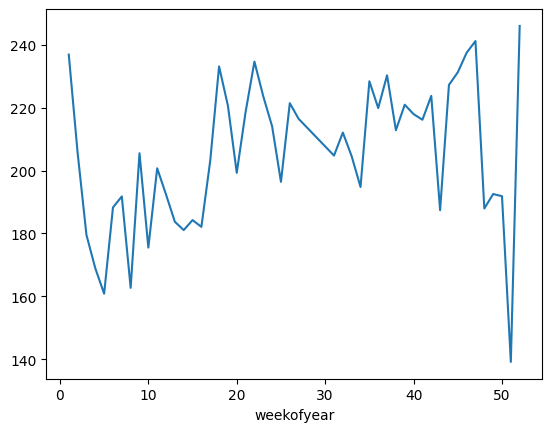

In [117]:
df_er.groupby('weekofyear')['waittime'].mean().plot(kind='line');

Q: Let's make another plot showing standard deviation error on the plot to see if the peaks and valleys could be considered "significantly different" from each other and not otherwise to be considered to "overlap".

A: The peaks and valleys are well within the standard deviation error of each other, so there are no significant differences between the peaks and valleys across week of year, across the entire dataset.  It is possible there might be significant differences in peaks and valley wait times across week of year if we looked at a more granular level like hospital.

One of the challenges is that this dataset is missing potential core weeks for "busy" or "high wait time" data in Calgary:  July weeks 28, 29, and 30.  These are the weeks that Calgary Stampede runs, and it is a major tourist attraction that attracts people from all over the world.  It is possible that these weeks are the busiest weeks of the year for Calgary hospitals, and that the mean wait times are significantly higher than the rest of the year, and that **if we had the data**, a significant pattern might emerge.

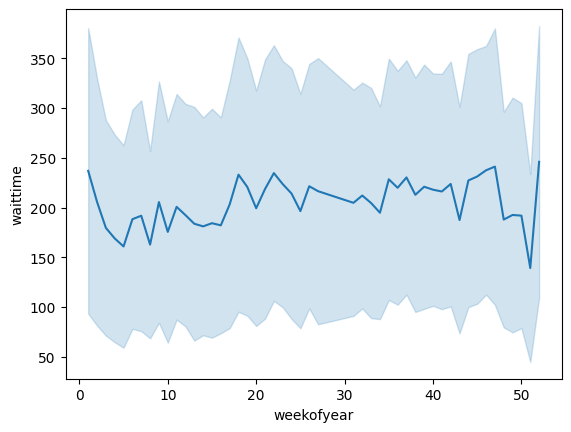

In [119]:
sns.lineplot(data=df_er, x='weekofyear', y='waittime', errorbar='sd');

Q: Are there statistically significant differences in wait times between cities?

A: It appears there may be!  (But likely only some cities versus others.  Perhaps this is due to the "type" of City - Urban vs. Rural?)

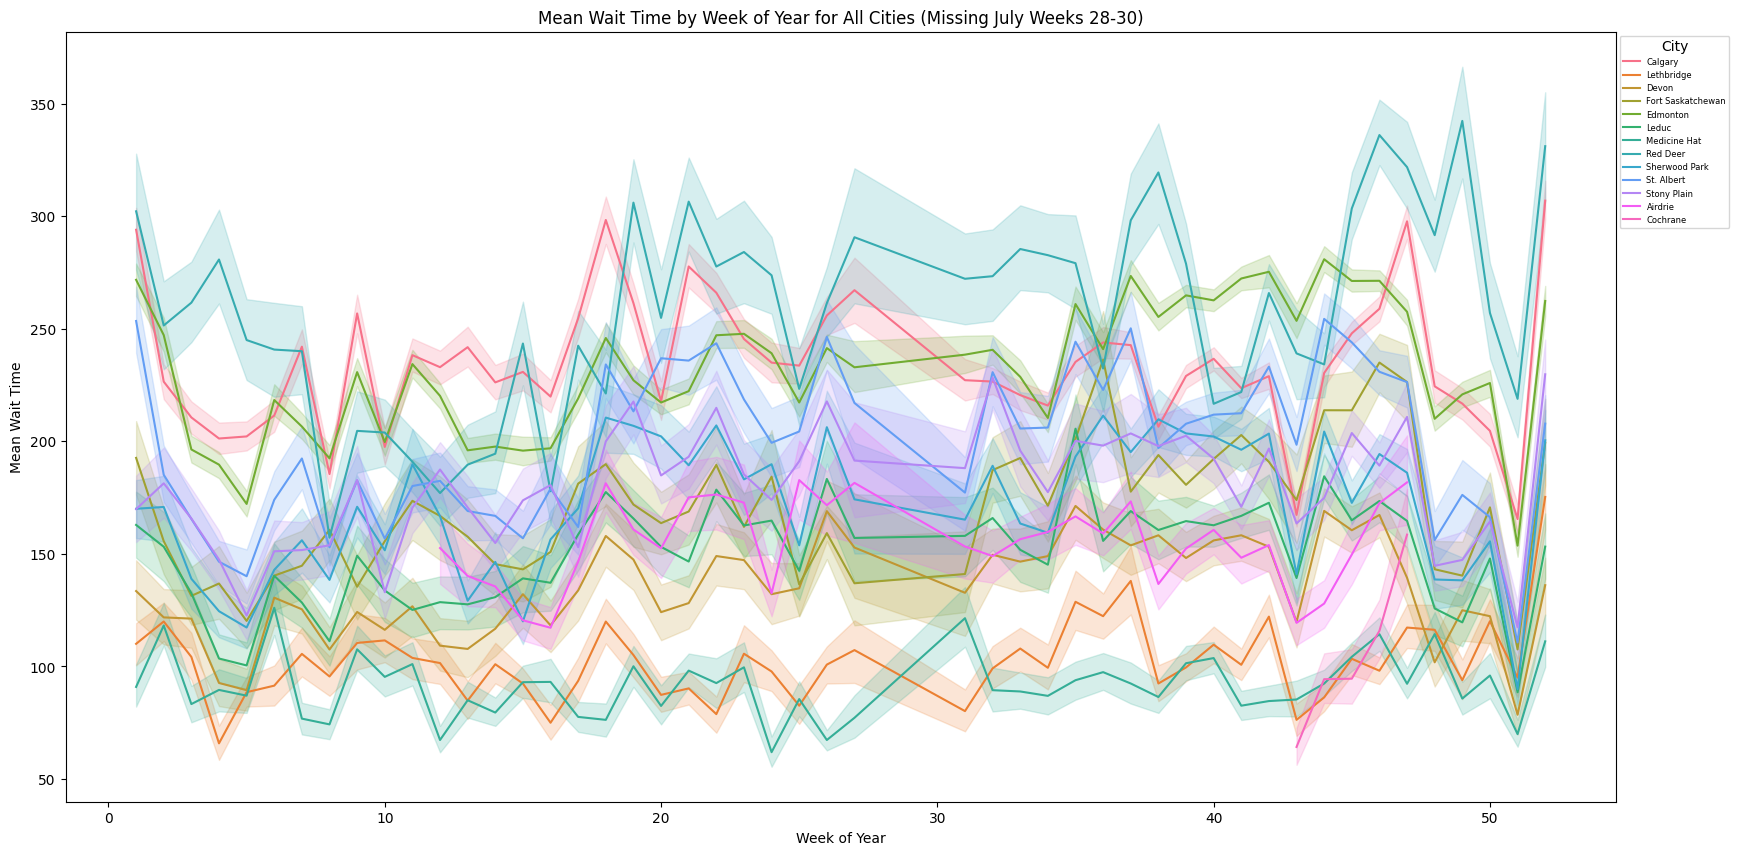

In [120]:
#sns.set_palette("tab10")

# Create figure and set color palette
fig, ax = plt.subplots(figsize=(20, 10))

# Create line plot
sns.lineplot(data=df, x='weekofyear', y='waittime', hue='city')

# Set title and labels
plt.title('Mean Wait Time by Week of Year for All Cities (Missing July Weeks 28-30)', fontsize=12);
plt.xlabel('Week of Year', fontsize=10);
plt.ylabel('Mean Wait Time', fontsize=10);

# Set legend
plt.legend(title='City', loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=6);

Q: Any patterns or obvious differences between Urban and Rural ER hospitals?

A: Peri and Rural look almost identical, and are lower than Urban in general.  Let's collapse Peri into Rural and see if the SD "cloud" overlaps.

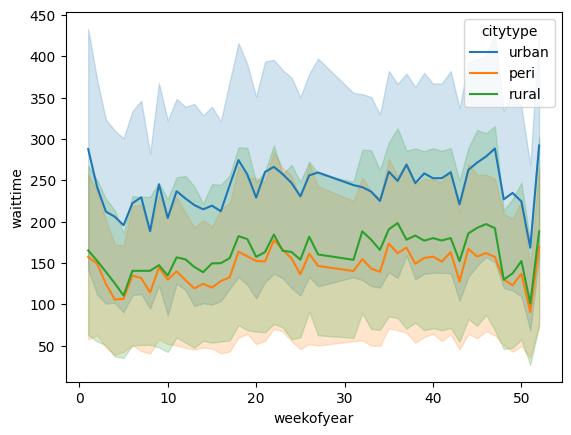

In [146]:
sns.lineplot(data=df_er, x='weekofyear', y='waittime', errorbar='sd', hue='citytype');

Q: What does the above graph look like when we collapse Peri and Rural hospitals into one category?

A: The means for Urban are in general higher than Rural (Peri and Rural), but there is a small overlap with the SD's, so there may not be a statistical difference - but there may be enough for a model to 'pick up' on and differentiate.

citytype
urban    109458
rural     72468
Name: count, dtype: int64

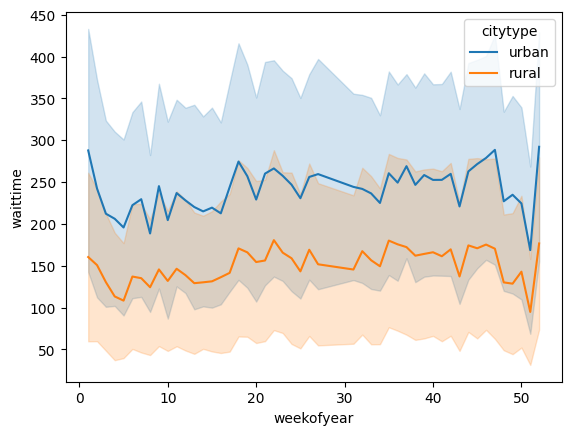

In [149]:
df_er_peri_collapse = df_er.copy()
Utility.collapse_periurban_to_rural(df_er_peri_collapse)
display(df_er_peri_collapse['citytype'].value_counts())

sns.lineplot(data=df_er_peri_collapse, x='weekofyear', y='waittime', errorbar='sd', hue='citytype');

Q: What do the patterns for Urban ER hospitals look like?

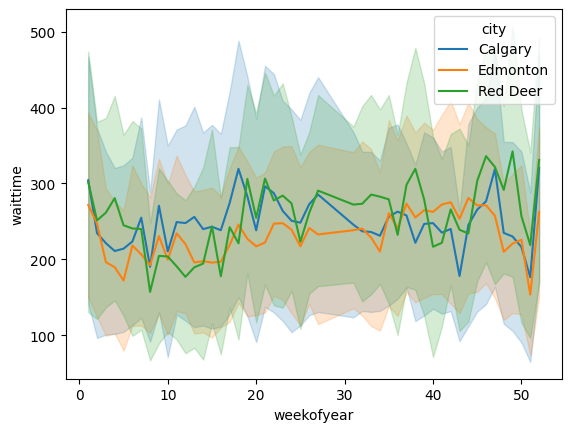

In [130]:
urban_mask = df_er['citytype'] == 'urban'
df_er_urban = df_er[urban_mask].copy()

sns.lineplot(data=df_er_urban, x='weekofyear', y='waittime', errorbar='sd', hue='city');

Q: Is there a significant difference between an arbitrary Urban city and an arbitrary Rural City?
* Calgary and Medicine Hat
* Calgary and Devon

In [ ]:
# What cities can I choose from?
df_er['city'].unique()

array(['Calgary', 'Lethbridge', 'Devon', 'Fort Saskatchewan', 'Edmonton',
       'Leduc', 'Medicine Hat', 'Red Deer', 'Sherwood Park', 'St. Albert',
       'Stony Plain'], dtype=object)

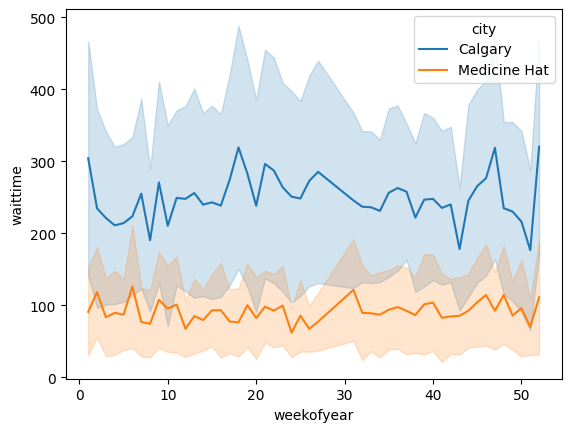

In [134]:
# Compare an Urban city to a Rural city - arbitrary
cities_list = ['Calgary', 'Medicine Hat']
df_er_2cities = df_er[df_er['city'].isin(cities_list)].copy()
df_er_2cities.head()

sns.lineplot(data=df_er_2cities, x='weekofyear', y='waittime', errorbar='sd', hue='city');

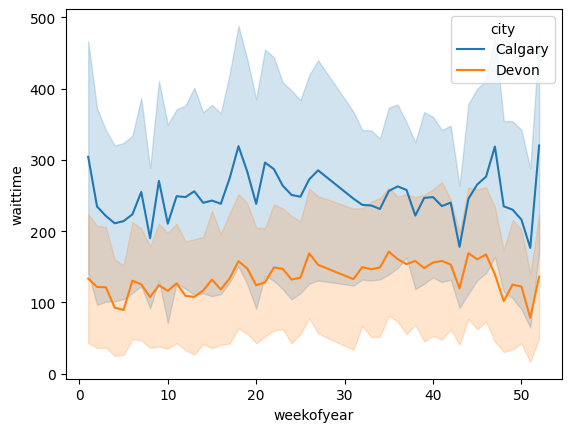

In [142]:
# Compare an Urban city to a Rural city - arbitrary
cities_list = ['Calgary', 'Devon']
df_er_2cities = df_er[df_er['city'].isin(cities_list)].copy()
df_er_2cities.head()

sns.lineplot(data=df_er_2cities, x='weekofyear', y='waittime', errorbar='sd', hue='city');

What does the pattern look like across all hospitals across hour?

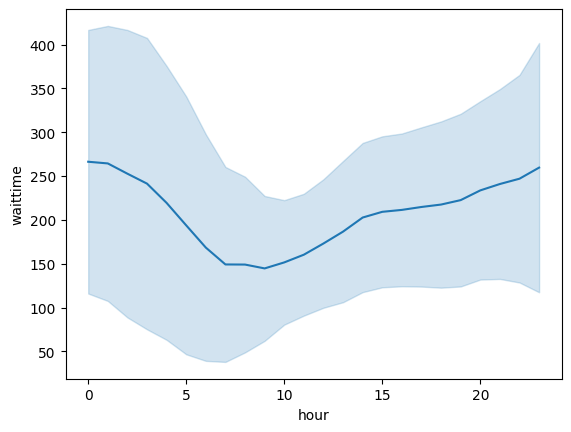

In [143]:
sns.lineplot(data=df_er, x='hour', y='waittime', errorbar='sd');

What does the pattern look like across all hospitals across dayperiod?

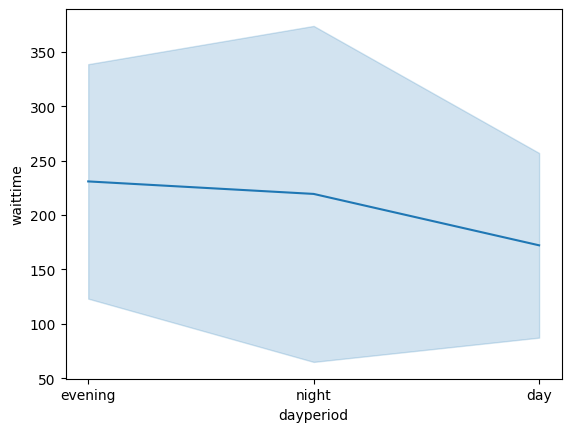

In [144]:
sns.lineplot(data=df_er, x='dayperiod', y='waittime', errorbar='sd');

Show the Rural vs. Urban hospitals from this dataset perspective:
* City population >= 100,000 ==> Urban
* Note: City populations were obtained by Microsoft Excel (Integration) which appear to by data from earlier than 2022/2023
    * This caused Lethbridge to be considered with a population of 98,406, categorizing it a 'rural' centre
    * ... whereas Red Deer to be considered with a population of 100,844, categorizing it as an 'urban' centre.
    * Today in 2023, both of these cities would be considered 'urban' centres by these same rules.

In [157]:
print("Rural Hospitals in this Dataset:")
display(df_er_peri_collapse[df_er_peri_collapse['citytype'] == 'rural'][['hospital', 'id']].drop_duplicates())
print("\nUrban Hospitals in this Dataset:")
display(df_er_peri_collapse[df_er_peri_collapse['citytype'] == 'urban'][['hospital', 'id']].drop_duplicates())

Rural Hospitals in this Dataset:


hospital    id
1        Chinook Regional Hospital   crh
2           Devon General Hospital   dgh
4     Fort Sask Community Hospital  fsch
6         Leduc Community Hospital   lch
7   Medicine Hat Regional Hospital  mhrh
18   Strathcona Community Hospital  schc
19     Sturgeon Community Hospital   sch
21          WestView Health Centre   whc


Urban Hospitals in this Dataset:


hospital        id
0         Alberta Children's Hospital       ach
3            Foothills Medical Centre       fmc
5        Grey Nuns Community Hospital      gnch
8     Misericordia Community Hospital       mch
9   Northeast Community Health Centre      nchc
10              Peter Lougheed Centre       plc
11         Red Deer Regional Hospital      rdrh
12         Rockyview General Hospital       rgh
13           Royal Alexandra Hospital       rah
16                South Health Campus       shc
17       Stollery Children's Hospital  stollery
20     University of Alberta Hospital       uah